# **SentimentArcs (Part 5): Time Series Feature Analysis**

By: Jon Chun
12 Jun 2021

References:

* Coming...

TODO:
* Demo datafiles
* Error detection around Crux points context (out of bounds)
* lex_discrete2continous (research binary->gaussian transformation fn)
* Text Preprocessing hints/tips/flowchart
* Clearly document workflow and partition across notebooks/libraries
* Code review and extraction to libraries
* Corpus ingestion for any format
* XAI (mlm false peak 1717SyuzhetR/1732SentimentR/1797robertalg15 adam watches war argument at dinner) 
* Centralize and Standardize Model name lists
* Normalize model SA Series lengths
* Standardize all SA Series with the same method
* Seamless report generation/file saving
* Get raw text from SentimentR
* Filter out non-printable characters
* Roll-over Crux-Points (SentNo+Sent/Parag) (plotly)
* Label/Roll-over Chapter/Sect No at Boundries
* Generate Report PDF/csv
* Option to select raw or discrete2continous transformation (Bing)
* Annotation functionality + Share/Collaboration of findings/reseearch
* clusters, centroids = kmeans1d.cluster(np.array(corpus_sentimentr_df['jockers_rinker']), k)
* plotly prefered library to save dynamic images: kaleido
* Correlation heatmaps: Justify choice of Spearman, Pearson, or other algo

Facts:
* SyuzhetR vs SentimentTime Clean/Preprocess
* V.Woolf - To The Lighthouse
* SyuzhetR Clean: 3511 (SyuzhetR Preprocessed) Sentences (SentimentTime Preprocessed) 3403
* SentimentTime Clean: (Raw) 3402  (Clean) 3402


Preprocessing of Corpus Textfile
* Put headers in ALL CAPS
* Put \n\n between each CHAPTER/BOOK or SECTION header or Paragraphs
* Keep your format/spacing consistent
* Try to use utf-8 (not cp1252 (e.g. \n <- \n\r)
* No leading blank lines, one trailing blank line at end of textfile
* Check for illegal, non-printable or other problematic code (e.g. curly single/double quotes)

# **Reference Code**

Surveys:
* https://github.com/prrao87/fine-grained-sentiment (20210409) Fine-grained SA (7 Models)


Other:
* https://github.com/annabiancajones/GA_capstone_project/blob/master/part3_mine_refine.ipynb
* https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6 CV

# **[RESTART RUNTIME] May be Required for these Libaries**

In [43]:
# If you see [Interactive namespace is empty] in response to the [%who] command below
#   your working with a fresh Linux Virtual Machine,
#   any previous work is lost,
#   and you need to sequentially execute this Notebook from the beginning 

%whos

Variable                    Type              Data/Info
-------------------------------------------------------
Corpus_Genre                str               novels
Corpus_Type                 str               new
FNAME_SENTIMENT_RAW         str               sentiment_raw_novels_new_lex2ml.json
IN_COLAB                    bool              True
Image                       type              <class 'IPython.core.display.Image'>
InteractiveShell            MetaHasTraits     <class 'IPython.core.inte<...>eshell.InteractiveShell'>
MIN_PARAG_LEN               int               10
MIN_SENT_LEN                int               3
MinMaxScaler                type              <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
Path_to_SentimentArcs       str               /gdrive/MyDrive/cdh/sentiment_arcs/
RobustScaler                type              <class 'sklearn.preproces<...>sing._data.RobustScaler'>
SLANG_DT                    dict              n=227
STOPWORDS_ADD_EN            lis

In [1]:
!pip install moepy

     |████████████████████████████████| 11.2 MB 4.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 895 kB 49.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
# [RESTART RUNTIME] May be Required (only needed for Plotly)

# Designed Security Hole in older version of PyYAML, must upgrade to use plotly

!pip install pyyaml==5.4.1

     |████████████████████████████████| 636 kB 3.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# [STEP 1] Manual Configuration

## [INPUT] Connect Google gDrive to this Jupyter Notebook

In [2]:
# [INPUT REQUIRED]: Authorize access to Google gDrive

# Connect this Notebook to your permanent Google Drive
#   so all generated output is saved to permanent storage there

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("Attempting to attach your Google gDrive to this Colab Jupyter Notebook")
  drive.mount('/gdrive')
else:
  print("Your Google gDrive is attached to this Colab Jupyter Notebook")

Attempting to attach your Google gDrive to this Colab Jupyter Notebook
Mounted at /gdrive


In [3]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.



# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/cdh/sentiment_arcs/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}

#@markdown (e.g. /gdrive/MyDrive/research/sentiment_arcs/)



# Step #2: Move to Parent directory of Sentiment_Arcs
# =======
parentdir_sentiment_arcs = '/'.join(Path_to_SentimentArcs.split('/')[:-2])
print(f'subdir_parent: {parentdir_sentiment_arcs}')
%cd $parentdir_sentiment_arcs


# Step #3: If project sentiment_arcs subdir does not exist, 
#          clone it from github
# =======
import os

if not os.path.isdir('sentiment_arcs'):
  # NOTE: This will not work until SentimentArcs becomes an open sourced PUBLIC repo
  # !git clone https://github.com/jon-chun/sentiment_arcs.git

  # Test on open access github repo
  !git clone https://github.com/jon-chun/nabokov_palefire.git


# Step #4: Change into sentiment_arcs subdir
# =======
%cd ./sentiment_arcs
# Test on open acess github repo
# %cd ./nabokov_palefire

# Step #5: Confirm contents of sentiment_arcs subdir
# =======
!ls 

subdir_parent: /gdrive/MyDrive/cdh
/gdrive/MyDrive/cdh
/gdrive/MyDrive/cdh/sentiment_arcs
 all_novels_new_4syuzhetr.json
 catboost_info
 config
 data
 docs
 huliu.rda
'IMDB Dataset.csv'
 imdb-dataset-of-50k-movie-reviews.zip
 jockersrinker.rda
 lexicons
 lmcd.rda
 loughranmcdonald.rda
 models__info.yaml
 notebooks
 nrc.rda
 old_sentiment_raw_novels_new_lex_ml_dnn.json
 plots
 senticnet.rda
 sentiment_clean
 sentiment_raw
 sentinet.rda
 sentiword.rda
 SentiWord.rda
 text_clean
 text_raw
 utils
 v0.9.2.zip
 v0.9.2.zip.1
 v0.9.2.zip.2


## [INPUT] Define Directory Tree Structure

In [4]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.



# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/cdh/sentiment_arcs/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}

#@markdown (e.g. /gdrive/MyDrive/research/sentiment_arcs/)



#@markdown **Sentiment Arcs Directory Structure** \
#@markdown \
#@markdown **1. Input Directories:** \
#@markdown (a) Raw textfiles in subdir: ./text_raw/(text_type)/  \
#@markdown (b) Cleaned textfiles in subdir: ./text_clean/(text_type)/ \
#@markdown \
#@markdown **2. Output Directories** \
#@markdown (1) Raw Sentiment time series datafiles and plots in subdir: ./sentiment_raw/(text_type) \
#@markdown (2) Cleaned Sentiment time series datafiles and plots in subdir: ./sentiment_clean/(text_type) \
#@markdown \
#@markdown **Which type of texts are you cleaning?** \

Corpus_Genre = "novels" #@param ["novels", "social_media", "finance"]

Corpus_Type = "new" #@param ["new", "reference"]

#@markdown Please check that the required textfiles and datafiles exist in the correct subdirectories before continuing.


# **[STEP 2] Automatic Configuration/Setup**

In [5]:
# Define all Sub/Dir global CONSTANTS

import os

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_subdirs.py'

get_subdirs(Corpus_Genre, Corpus_Type, 'lex2ml')

Verify the Directory Structure:

-------------------------------

          [Corpus Genre]: novels

           [Corpus Type]: new


   [FNAME_SENTIMENT_RAW]: sentiment_raw_novels_new_lex2ml.json


       [SUBDIR_TEXT_RAW]: ./text_raw/novels_text_new_raw/

     [SUBDIR_TEXT_CLEAN]: ./text_clean/novels_text_new_clean/

  [SUBDIR_SENTIMENT_RAW]: ./sentiment_raw/novels_sentiment_new_raw/

[SUBDIR_SENTIMENT_CLEAN]: ./sentiment_clean/novels_sentiment_new_clean/

          [SUBDIR_PLOTS]: ./plots/

           [SUBDIR_DATA]: ./data/

          [SUBDIR_UTILS]: ./utils/



## Configure Jupyter Notebook

In [6]:
# Configure Jupyter

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from IPython.display import Image
from ipywidgets import widgets, interactive

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Read YAML Configuration for Corpus and Models 

In [7]:
# Define all Corpus Texts & Ensemble Models as global CONSTANTS

import yaml

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/read_yaml.py'

read_yaml(Corpus_Genre, Corpus_Type)

print('SentimentArcs Model Ensemble ------------------------------\n')
model_titles_ls = models_titles_dt.keys()
print('\n'.join(model_titles_ls))


print('\n\nCorpus Texts ------------------------------\n')
corpus_titles_ls = corpus_titles_dt.keys()
print('\n'.join(corpus_titles_ls))


print(f'\n\nThere are {len(model_titles_ls)} Models in the SentimentArcs Ensemble above.\n')
print(f'\nThere are {len(corpus_titles_ls)} Texts in the Corpus above.\n')
print('\n')

SentimentArcs Model Ensemble ------------------------------

AutoGluon_Text
BERT_2IMDB
BERT_Dual_Coding
BERT_Multilingual
BERT_Yelp
CNN_DNN
Distilled_BERT
FLAML_AutoML
Fully_Connected_Network
HyperOpt_CNN_Flair_AutoML
LSTM_DNN
Logistic_Regression
Logistic_Regression_CV
Multilingual_CNN_Stanza_AutoML
Multinomial_Naive_Bayes
Pattern
Random_Forest
RoBERTa_Large_15DB
RoBERTa_XML_8Language
SentimentR_JockersRinker
SentimentR_Jockers
SentimentR_Bing
SentimentR_NRC
SentimentR_SentiWord
SentimentR_SenticNet
SentimentR_LMcD
SentimentR_SentimentR
PySentimentR_JockersRinker
PySentimentR_Huliu
PySentimentR_NRC
PySentimentR_SentiWord
PySentimentR_SenticNet
PySentimentR_LMcD
SyuzhetR_AFINN
SyuzhetR_Bing
SyuzhetR_NRC
SyuzhetR_SyuzhetR
T5_IMDB
TextBlob
VADER
AFINN
XGBoost


Corpus Texts ------------------------------

scollins_thehungergames1
cmieville_thecityandthecity


There are 42 Models in the SentimentArcs Ensemble above.


There are 2 Texts in the Corpus above.





## Install Python Libraries

In [8]:
# Intentionally left blank

## Load Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('max_colwidth', 100) # -1)

from glob import glob
import copy
# import yaml # Already done above
import json # Already done above

2022-03-08 20:46:13,714 : INFO : NumExpr defaulting to 2 threads.


In [10]:
# Time Series

from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess
from statsmodels import robust as sm_robust

from moepy import lowess, eda
lowess_moepy = lowess.Lowess()

from sklearn.preprocessing import MinMaxScaler   # To normalize time series
from sklearn.preprocessing import StandardScaler # To sandardize time series
from sklearn.preprocessing import RobustScaler   # To deal with outliers

scaler_minmax = MinMaxScaler()
scaler_zscore = StandardScaler()
scaler_robust = RobustScaler()

In [11]:
# Plotly Visualizations
# Note: Security Hole in default, must upgrade above
#       !pip install pyyaml==5.4.1

import plotly.graph_objects as go
import plotly.express as px
import plotly

## Define Global Parameters




In [41]:
# Define Globals

# Main data structure: Dictionary (key=text_name) of DataFrames (cols: text_raw, text_clean)
corpus_texts_dt = {}

# corpus_sa_dt = {}

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_globals.py'

SLANG_DT.keys()


dict_keys(['$', '€', '4ao', 'a.m', 'a3', 'aamof', 'acct', 'adih', 'afaic', 'afaict', 'afaik', 'afair', 'afk', 'app', 'approx', 'apps', 'asap', 'asl', 'atk', 'ave.', 'aymm', 'ayor', 'b&b', 'b+b', 'b.c', 'b2b', 'b2c', 'b4', 'b4n', 'b@u', 'bae', 'bak', 'bbbg', 'bbc', 'bbias', 'bbl', 'bbs', 'be4', 'bfn', 'blvd', 'bout', 'brb', 'bros', 'brt', 'bsaaw', 'btw', 'bwl', 'c/o', 'cet', 'cf', 'cia', 'csl', 'cu', 'cul8r', 'cv', 'cwot', 'cya', 'cyt', 'dae', 'dbmib', 'diy', 'dm', 'dwh', 'e123', 'eet', 'eg', 'embm', 'encl', 'encl.', 'etc', 'faq', 'fawc', 'fb', 'fc', 'fig', 'fimh', 'ft.', 'ft', 'ftl', 'ftw', 'fwiw', 'fyi', 'g9', 'gahoy', 'gal', 'gcse', 'gfn', 'gg', 'gl', 'glhf', 'gmt', 'gmta', 'gn', 'g.o.a.t', 'goat', 'goi', 'gps', 'gr8', 'gratz', 'gyal', 'h&c', 'hp', 'hr', 'hrh', 'ht', 'ibrb', 'ic', 'icq', 'icymi', 'idc', 'idgadf', 'idgaf', 'idk', 'ie', 'i.e', 'ifyp', 'IG', 'iirc', 'ilu', 'ily', 'imho', 'imo', 'imu', 'iow', 'irl', 'j4f', 'jic', 'jk', 'jsyk', 'l8r', 'lb', 'lbs', 'ldr', 'lmao', 'lmfao', 

## Setup Matplotlib Style

* https://matplotlib.org/stable/tutorials/introductory/customizing.html

In [13]:
# Configure Matplotlib

# View available styles
# plt.style.available

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/config_matplotlib.py'

config_matplotlib()

print('Matplotlib Configuration ------------------------------\n')
plt.rcParams.keys()
print('\n  Edit ./utils/config_matplotlib.py to change')




 New figure size:  (20, 10)
Matplotlib Configuration ------------------------------



KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri


  Edit ./utils/config_matplotlib.py to change


## Setup Seaborn Style

In [14]:
# Configure Seaborn

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/config_seaborn.py'

config_seaborn()

print('Seaborn Configuration ------------------------------\n')
# print('\n  Update ./utils/config_seaborn.py to display seaborn settings')




Seaborn Configuration ------------------------------



## Utility Functions

### Generate Convenient Data Lists

In [15]:
# Derive List of Texts in Corpus a)keys and b)full author and titles

print('Dictionary: corpus_titles_dt')
corpus_titles_dt
print('\n')

corpus_texts_ls = list(corpus_titles_dt.keys())
print(f'\nCorpus Texts:')
for akey in corpus_texts_ls:
  print(f'  {akey}')
print('\n')

print(f'\nNatural Corpus Titles:')
corpus_titles_ls = [x[0] for x in list(corpus_titles_dt.values())]
for akey in corpus_titles_ls:
  print(f'  {akey}')


Dictionary: corpus_titles_dt


{'cmieville_thecityandthecity': ['The City and The City by China Mieville',
  2009,
  0],
 'scollins_thehungergames1': ['The Hunger Games 1 by Suzanne Collins ',
  2008,
  0]}




Corpus Texts:
  scollins_thehungergames1
  cmieville_thecityandthecity



Natural Corpus Titles:
  The Hunger Games 1 by Suzanne Collins 
  The City and The City by China Mieville


In [16]:
# get_model_families()

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_model_families.py'

ensemble_models_dt = get_model_famalies(models_titles_dt)

print('\nTest: Lexicon Family of Models:')
ensemble_models_dt['lexicon']


There are 12 Lexicon Models
  Lexicon Model #0: sentimentr_sentimentr
  Lexicon Model #1: pysentimentr_jockersrinker
  Lexicon Model #2: pysentimentr_huliu
  Lexicon Model #3: pysentimentr_nrc
  Lexicon Model #4: pysentimentr_sentiword
  Lexicon Model #5: pysentimentr_senticnet
  Lexicon Model #6: pysentimentr_lmcd
  Lexicon Model #7: syuzhetr_afinn
  Lexicon Model #8: syuzhetr_bing
  Lexicon Model #9: syuzhetr_nrc
  Lexicon Model #10: syuzhetr_syuzhetr
  Lexicon Model #11: afinn

There are 9 Heuristic Models
  Heuristic Model #0: pattern
  Heuristic Model #1: sentimentr_jockersrinker
  Heuristic Model #2: sentimentr_jockers
  Heuristic Model #3: sentimentr_bing
  Heuristic Model #4: sentimentr_nrc
  Heuristic Model #5: sentimentr_sentiword
  Heuristic Model #6: sentimentr_senticnet
  Heuristic Model #7: sentimentr_lmcd
  Heuristic Model #8: vader

There are 8 Traditional ML Models
  Traditional ML Model #0: autogluon
  Traditional ML Model #1: flaml
  Traditional ML Model #2: logreg


['sentimentr_sentimentr',
 'pysentimentr_jockersrinker',
 'pysentimentr_huliu',
 'pysentimentr_nrc',
 'pysentimentr_sentiword',
 'pysentimentr_senticnet',
 'pysentimentr_lmcd',
 'syuzhetr_afinn',
 'syuzhetr_bing',
 'syuzhetr_nrc',
 'syuzhetr_syuzhetr',
 'afinn']

### File Functions

In [17]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/file_utils.py'

# TODO: Not used? Delete?
# get_fullpath(text_title_str, ftype='data_clean', fig_no='', first_note = '',last_note='', plot_ext='png', no_date=False)

# **[STEP 3] Read, Merge & Clean All Raw Sentiment Data**

## Read All Raw Sentiment Data

In [45]:
from pandas.core.arrays.numeric import T
print(f'Reading from SUBDIR_SENTIMENT_RAW: {SUBDIR_SENTIMENT_RAW}\n')
sentiment_raw_datafile_ls = os.listdir(SUBDIR_SENTIMENT_RAW)

corpus_texts_dt = {}
first_bo = T

!ls -altr $SUBDIR_SENTIMENT_RAW
print('\n')

for i,afile in enumerate(sentiment_raw_datafile_ls):
  temp_dt = {}
  print(f'File #{i}: {afile}')
  afile_key = afile.split('.')[0].split('_')[-1]
  print(f'         {afile_key}')
  temp_dt = read_dict_dfs(in_file=afile, in_dir=SUBDIR_SENTIMENT_RAW)
  corpus_titles_ls = list(temp_dt.keys())
  # print(corpus_titles_ls)
  for j, atitle in enumerate(corpus_titles_ls):
    print(f'    Text #{j}: {atitle}')
    if (atitle in corpus_texts_dt.keys()):
      print(f'Append:')
      corpus_texts_dt[atitle] = pd.concat([corpus_texts_dt[atitle],temp_dt[atitle]], axis=1)
      # corpus_texts_dt[atitle] = temp_dt[atitle]
      # first_bo = False
    else:
      print(f'  New:')
      corpus_texts_dt[atitle] = temp_dt[atitle].copy()

Reading from SUBDIR_SENTIMENT_RAW: ./sentiment_raw/novels_sentiment_new_raw/

total 45862
-rw------- 1 root root 12122776 Mar  3 20:46 all_novels_new_pymodels.json
-rw------- 1 root root 13714981 Mar  4 05:10 sentiment_raw_novels_new_syuzhetr2sentimentr.json
-rw------- 1 root root 12122777 Mar  4 06:58 sentiment_raw_novels_new_lex2ml.json
-rw------- 1 root root  9000162 Mar  4 07:24 sentiment_raw_novels_new_dnn2transformers.json


File #0: all_novels_new_pymodels.json
         pymodels
    Text #0: cmieville_thecityandthecity
  New:
    Text #1: scollins_thehungergames1
  New:
File #1: sentiment_raw_novels_new_syuzhetr2sentimentr.json
         syuzhetr2sentimentr
    Text #0: cmieville_thecityandthecity
Append:
    Text #1: scollins_thehungergames1
Append:
File #2: sentiment_raw_novels_new_lex2ml.json
         lex2ml
    Text #0: cmieville_thecityandthecity
Append:
    Text #1: scollins_thehungergames1
Append:
File #3: sentiment_raw_novels_new_dnn2transformers.json
         dnn2transfo

In [46]:
corpus_texts_dt.keys()

dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

In [47]:
corpus_texts_dt[corpus_titles_ls[1]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   afinn                         9021 non-null   float64
 1   flair                         9021 non-null   float64
 2   pattern                       9021 non-null   float64
 3   pysentimentr_huliu            9021 non-null   float64
 4   pysentimentr_jockersrinker    9021 non-null   float64
 5   pysentimentr_lmcd             9021 non-null   float64
 6   pysentimentr_nrc              9021 non-null   float64
 7   pysentimentr_senticnet        9021 non-null   float64
 8   pysentimentr_sentiword        9021 non-null   float64
 9   stanza                        9021 non-null   float64
 10  text_clean                    9021 non-null   object 
 11  text_raw                      9021 non-null   object 
 12  textblob                      9021 non-null   float64
 13  vad

In [48]:
ensemble_ls = list(set(corpus_texts_dt[corpus_titles_ls[1]].columns) - set(['text_clean','text_raw']))
ensemble_ls

['pattern',
 'pysentimentr_lmcd',
 'huggingface',
 'sentimentr_socal_google',
 'sentimentr_sentiword',
 'nlptown',
 'roberta15lg',
 'sentimentr_huliu',
 'afinn',
 'syuzhetr_nrc',
 'imdb2way',
 'pysentimentr_nrc',
 'syuzhetr_bing',
 'hinglish',
 'stanza',
 'vader',
 'pysentimentr_huliu',
 'sentimentr_jockers',
 'textblob',
 'pysentimentr_sentiword',
 'robertaxml8lang',
 'syuzhetr_syuzhet',
 'sentimentr_nrc',
 'syuzhetr_afinn',
 't5imdb50k',
 'pysentimentr_jockersrinker',
 'pysentimentr_senticnet',
 'yelp',
 'flair',
 'sentimentr_loughran_mcdonald',
 'sentimentr_jockersrinker',
 'sentimentr_senticnet']

## Delete Duplicate Columns

In [49]:
# Check for any duplicated columns/models

# corpus_texts_dt[atext].columns.duplicated()
print(corpus_texts_dt[corpus_titles_ls[0]].columns.value_counts())

print('\n')
next(iter(zip(corpus_texts_dt[corpus_titles_ls[0]].columns.duplicated(), corpus_texts_dt[corpus_titles_ls[0]].columns)))

text_raw                        4
text_clean                      4
pysentimentr_sentiword          2
flair                           2
vader                           2
textblob                        2
stanza                          2
afinn                           2
pysentimentr_senticnet          2
pysentimentr_nrc                2
pysentimentr_lmcd               2
pysentimentr_jockersrinker      2
pysentimentr_huliu              2
pattern                         2
syuzhetr_nrc                    1
t5imdb50k                       1
robertaxml8lang                 1
roberta15lg                     1
nlptown                         1
imdb2way                        1
huggingface                     1
hinglish                        1
syuzhetr_syuzhet                1
sentimentr_loughran_mcdonald    1
syuzhetr_bing                   1
syuzhetr_afinn                  1
sentimentr_socal_google         1
sentimentr_sentiword            1
sentimentr_senticnet            1
sentimentr_nrc

(False, 'afinn')

In [50]:
# Check for Duplicate Models/Col names

column_list = pd.Series()

for atext_no in range(len(corpus_texts_dt.keys())):
  atext = corpus_texts_ls[atext_no]
  df = corpus_texts_dt[atext]
  print(f'\n\n\nProcessing #{atext_no}: {atext}')
  # col_dups_ct = corpus_texts_dt[atext].columns.duplicated().sum()
  # col_dups_ls = corpus_texts_dt[atext].columns[corpus_texts_dt[atext].columns.duplicated()]

  col_dups_ct = df.columns.duplicated().sum()

  if col_dups_ct > 0:
    col_dups_ls = df.columns[df.columns.duplicated()]
    print(f'\nBEFORE: {col_dups_ct} duplicated columns')
    print(f'  {", ".join(col_dups_ls)}')  

    # get names of duplicated columns
    column_list = df.columns.value_counts()
    col_del_ls = column_list[column_list>1]
    col_del_ls

    # Add '_dup' suffix to columns repeated more than once (keep one original without _dup suffix)
    my_suffix = '_dup'
    df.columns = [name if (duplicated == False & ~(name.endswith('_dup'))) else name + my_suffix for duplicated, name in zip(df.columns.duplicated(), df.columns)]

    # Drop all columns with '_dup' suffix
    col_drop_ls = [x for x in df.columns if x.endswith('_dup')]
    df.drop(columns=col_drop_ls, inplace=True)

    # check to see if table has duplicate column names which prohibits upload to BigQuery - TRUE Desired
    len(df.columns) == len(set(df.columns))

  else:
    print(f'No Duplicated Columns')




Processing #0: scollins_thehungergames1

BEFORE: 18 duplicated columns
  text_clean, text_raw, afinn, flair, pattern, pysentimentr_huliu, pysentimentr_jockersrinker, pysentimentr_lmcd, pysentimentr_nrc, pysentimentr_senticnet, pysentimentr_sentiword, stanza, text_clean, text_raw, textblob, vader, text_clean, text_raw


text_raw                      4
text_clean                    4
pysentimentr_sentiword        2
flair                         2
vader                         2
textblob                      2
stanza                        2
afinn                         2
pysentimentr_senticnet        2
pysentimentr_nrc              2
pysentimentr_lmcd             2
pysentimentr_jockersrinker    2
pysentimentr_huliu            2
pattern                       2
dtype: int64

True




Processing #1: cmieville_thecityandthecity

BEFORE: 18 duplicated columns
  text_clean, text_raw, afinn, flair, pattern, pysentimentr_huliu, pysentimentr_jockersrinker, pysentimentr_lmcd, pysentimentr_nrc, pysentimentr_senticnet, pysentimentr_sentiword, stanza, text_clean, text_raw, textblob, vader, text_clean, text_raw


text_raw                      4
text_clean                    4
pysentimentr_sentiword        2
flair                         2
vader                         2
textblob                      2
stanza                        2
afinn                         2
pysentimentr_senticnet        2
pysentimentr_nrc              2
pysentimentr_lmcd             2
pysentimentr_jockersrinker    2
pysentimentr_huliu            2
pattern                       2
dtype: int64

True

In [51]:
# After deleting duplicates, check remaining cols/models of last text processed

corpus_texts_dt[corpus_titles_ls[0]].columns

Index(['afinn', 'flair', 'pattern', 'pysentimentr_huliu',
       'pysentimentr_jockersrinker', 'pysentimentr_lmcd', 'pysentimentr_nrc',
       'pysentimentr_senticnet', 'pysentimentr_sentiword', 'stanza',
       'text_clean', 'text_raw', 'textblob', 'vader', 'sentimentr_huliu',
       'sentimentr_jockers', 'sentimentr_jockersrinker',
       'sentimentr_loughran_mcdonald', 'sentimentr_nrc',
       'sentimentr_senticnet', 'sentimentr_sentiword',
       'sentimentr_socal_google', 'syuzhetr_afinn', 'syuzhetr_bing',
       'syuzhetr_nrc', 'syuzhetr_syuzhet', 'hinglish', 'huggingface',
       'imdb2way', 'nlptown', 'roberta15lg', 'robertaxml8lang', 't5imdb50k',
       'yelp'],
      dtype='object')

## Interpolate and NaN/None Values

In [52]:
# TODO:

## Visually Verify Data

<AxesSubplot:title={'center':'The Hunger Games 1 by Suzanne Collins \nSentiment Analysis (SMA 10%)\nNo Normalization/Standardization'}>

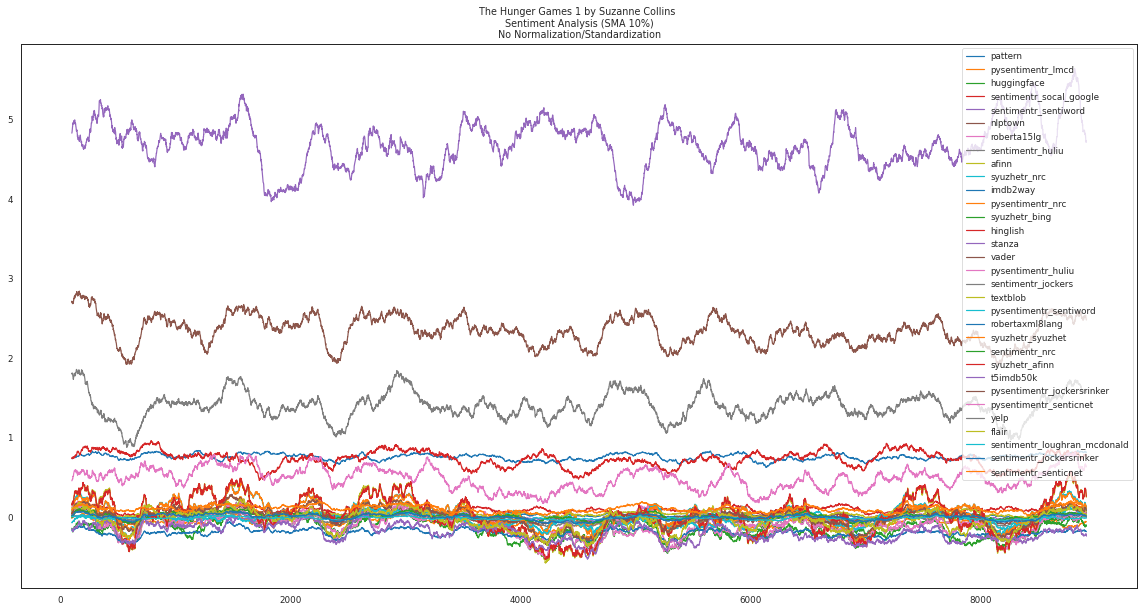

<AxesSubplot:title={'center':'The City and The City by China Mieville\nSentiment Analysis (SMA 10%)\nNo Normalization/Standardization'}>

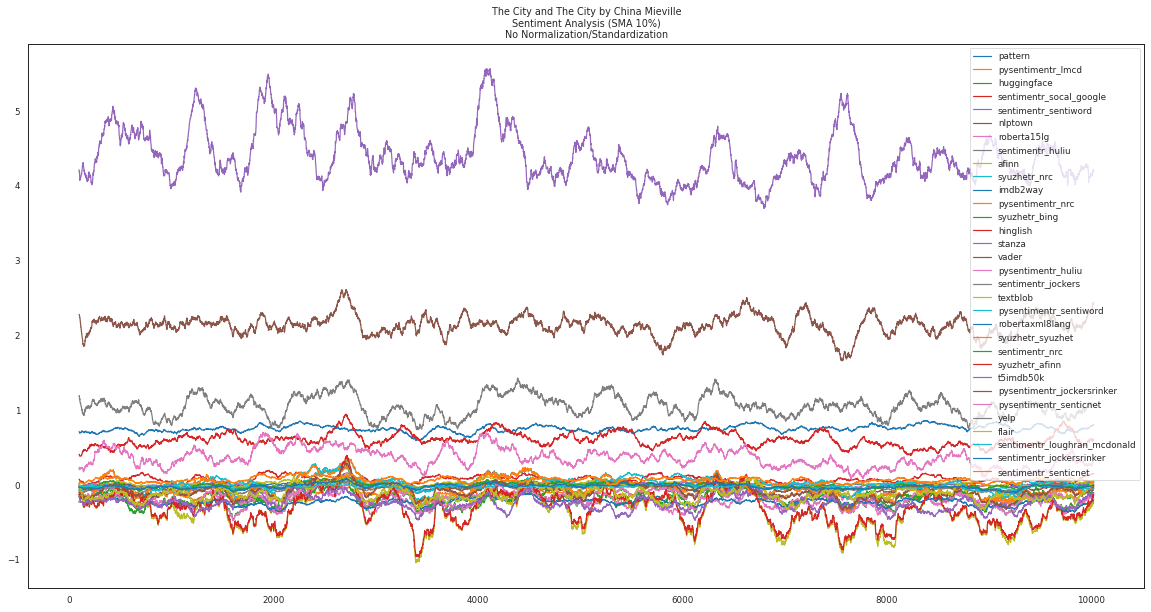

In [53]:
for i, atext in enumerate(corpus_texts_ls):
    
  atitle = f'{corpus_titles_dt[atext][0]}\nSentiment Analysis (SMA 10%)\nNo Normalization/Standardization'
  corpus_texts_dt[atext][ensemble_ls].rolling(200, center=True).mean().plot(title=atitle) 
  plt.show();              

# **[STEP 4] Time Series Processing**

## Check for Clean DataFrame

In [27]:
# Check for NaN values
# TODO:

print(f'Any Null values: [{corpus_texts_dt[corpus_titles_ls[0]].isnull().values.any()}]')

print('\n')

corpus_texts_dt[corpus_titles_ls[0]].columns.duplicated()

print('\n')

print(corpus_texts_dt[corpus_titles_ls[0]].columns.value_counts())

print('\n')

next(iter(zip(corpus_texts_dt[atext].columns.duplicated(), corpus_texts_dt[atext].columns)))

Any Null values: [False]




array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])



afinn                           1
syuzhetr_syuzhet                1
sentimentr_senticnet            1
sentimentr_sentiword            1
sentimentr_socal_google         1
syuzhetr_afinn                  1
syuzhetr_bing                   1
syuzhetr_nrc                    1
hinglish                        1
flair                           1
huggingface                     1
imdb2way                        1
nlptown                         1
roberta15lg                     1
robertaxml8lang                 1
t5imdb50k                       1
sentimentr_nrc                  1
sentimentr_loughran_mcdonald    1
sentimentr_jockersrinker        1
sentimentr_jockers              1
sentimentr_huliu                1
vader                           1
textblob                        1
text_raw                        1
text_clean                      1
stanza                          1
pysentimentr_sentiword          1
pysentimentr_senticnet          1
pysentimentr_nrc                1
pysentimentr

(False, 'afinn')

## Robust to Outliers

Comparison Test: (a) Manual IRQ Clipping vs (b) RobustScaler()


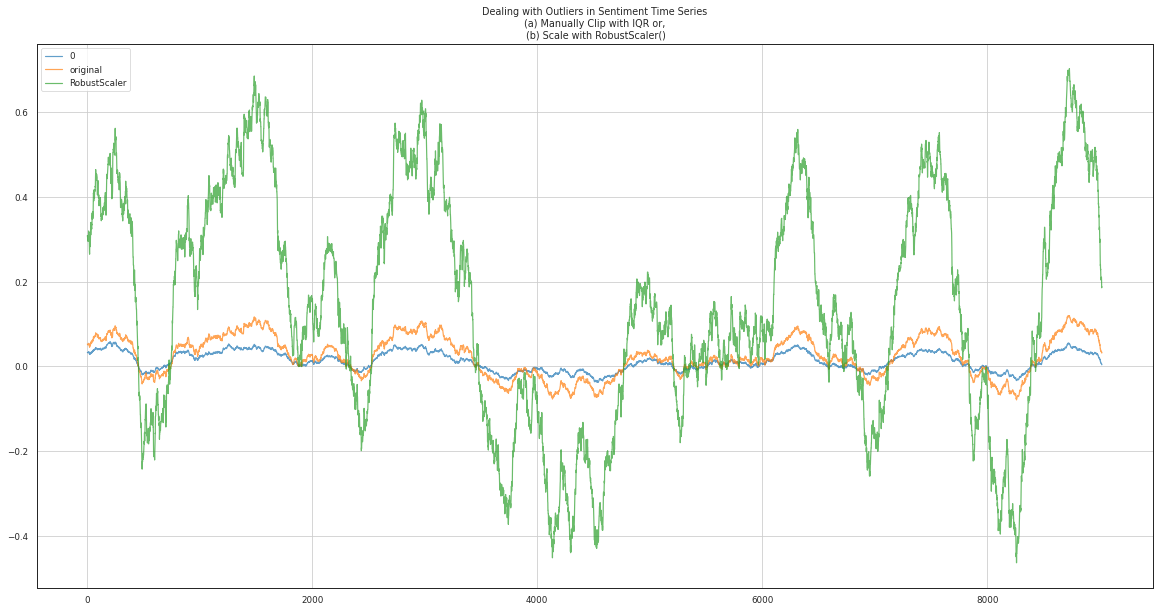

In [54]:
# Clip Outliers based on IQR: RobustScaler())

def clip_outliers(floats_ser):
  '''
  Given a pd.Series of float values
  Return a list with outliers removed, values limited within 3 median absolute deviations from median
  '''
  # https://www.statsmodels.org/stable/generated/statsmodels.robust.scale.mad.html#statsmodels.robust.scale.mad

  # Old mean/std, less robust
  # ser_std = floats_ser.std()
  # ser_median = floats_ser.mean() # TODO: more robust: asym/outliers -> median/IQR or median/median abs deviation

  floats_np = np.array(floats_ser)
  ser_median = floats_ser.median()
  ser_mad = sm_robust.mad(floats_np)
  # print(f'ser_median = {ser_median}')
  # print(f'ser_mad = {ser_mad}')

  if ser_mad == 0:
    # for TS with small ranges (e.g. -1.0 to +1.0) Median Abs Deviation = 0
    #   so pass back the original time series
    floats_clip_ls = list(floats_ser)

  else:
    ser_oldmax = floats_ser.max()
    ser_oldmin = floats_ser.min()
    # print(f'ser_max = {ser_oldmax}')
    # print(f'ser_min = {ser_oldmin}')

    ser_upperlim = ser_median + 2.5*ser_mad
    ser_lowerlim = ser_median - 2.5*ser_mad
    # print(f'ser_upperlim = {ser_upperlim}')
    # print(f'ser_lowerlim = {ser_lowerlim}')

    # Clip outliers to max or min values
    floats_clip_ls = np.clip(floats_np, ser_lowerlim, ser_upperlim)
    # print(f'max floast_ls {floats_ls.max()}')

    # def map2range(value, low, high, new_low, new_high):
    #   '''map a value from one range to another'''
    #   return value * 1.0 / (high - low + 1) * (new_high - new_low + 1)

    # Map all float values to range [-1.0 to 1.0]
    # floats_clip_sig_ls = [map2range(i, ser_oldmin, ser_oldmax, ser_upperlim, ser_lowerlim) for i in floats_clip_ls]

    # listmax_fl = float(max(floats_ls))
    # floats_ls = [i/listmax_fl for i in floats_ls]
    #floats_ls = [1/(1+math.exp(-i)) for i in floats_ls]

  return floats_clip_ls  # floats_clip_sig_ls

# Test
# Will not work on first run as corpus_sents_df is not defined yet

# data = np.array([1, 4, 4, 7, 12, 13, 16, 19, 22, 24])
# test_ls = clip_outliers(pd.Series(data))

print('Comparison Test: (a) Manual IRQ Clipping vs (b) RobustScaler()')
# Plot #1: Clipped Outliers with IQR
test_ls = clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['vader'])
# test_ls = clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['afinn'].iloc[0])
# print(f'new min is {min(test_ls)}')
# print(f'new max is {max(test_ls)}')
pd.DataFrame(test_ls).rolling(300, center=True, min_periods=0).mean().plot(label='clipped', alpha=0.7);
corpus_texts_dt[corpus_texts_ls[0]]['vader'].rolling(300, center=True, min_periods=0).mean().plot(label='original', alpha=0.7)

# transformer = scaler_robust.fit(corpus_texts_dt[corpus_texts_ls[0]]['vader'].values.reshape(-1, 1))

# Plot #2: Scale Outliers with RobustScaler()
test_df = corpus_texts_dt[corpus_texts_ls[0]]['vader'].copy(deep=True) #   pd.DataFrame()
# test_df = pd.DataFrame({'vader': scaler_robust.fit_transform(np.array(corpus_texts_dt[corpus_texts_ls[0]]['vader']).reshape(-1, 1))})
test_df['vader_std'] = pd.Series(scaler_robust.fit_transform(np.array(corpus_texts_dt[corpus_texts_ls[0]]['vader']).reshape(-1, 1)).flatten())
test_df['vader_std'].rolling(300, center=True, min_periods=0).mean().plot(label='RobustScaler', alpha=0.7)

plt.title('Dealing with Outliers in Sentiment Time Series\n(a) Manually Clip with IQR or,\n (b) Scale with RobustScaler()')
plt.grid(True)
plt.legend()
plt.show();

In [ ]:
# Deal with Outliers: (a) Manually clip with IQR, or (b) Automatically Scale RobustScaler()
"""
for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f'Text #{i}: {atext}')

  fig = plt.figure()
  ax = plt.subplot(111)

  models_rstd_ls = []
  for j, amodel in enumerate(ensemble_ls):
    amodel_rstd = f'{amodel}_rstd'
    win_10per = int(0.10 * corpus_texts_dt[atext][amodel].shape[0])
    # print(f'  Model #{j}: {amodel} (Model_Std: {amodel_rstd})')
    # clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['vader'])
    
    # Option (a): Manually Clip with IQR
    corpus_texts_dt[atext][amodel_rstd] = pd.Series(clip_outliers(corpus_texts_dt[atext][amodel])) # .reshape(-1,1)).flatten())

    # Option (b): Automatically Scale wit scikit-learns ScalerRobust()
    # corpus_texts_dt[atext][amodel_rstd] = pd.Series(scaler_robust.fit_transform(np.array(corpus_texts_dt[atext][amodel]).reshape(-1,1)).flatten())

    # Plot
    _ = ax.plot(corpus_texts_dt[atext][amodel_rstd].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rstd, alpha=0.3)

    models_rstd_ls.append(amodel_rstd)

 
  # Plot Median of Ensemble
  _ = ax.plot(corpus_texts_dt[atext][models_rstd_ls].median(axis=1).rolling(win_10per, center=True, min_periods=0).mean(), label='Ensemble Median', color='r', linewidth=3)

  # Shrink current axis by 20%
  # box = ax.get_position()
  # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

  # Put a legend to the right of the current axis
  _ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.grid(True, alpha=0.3)
  atitle = plt.title(f'{corpus_titles_dt[atext][0]}\nSentimentArc Ensemble of {len(ensemble_ls)} Models\nSmoothed: SMA (window=10%)\nClipped with IQR + zScore Standardized')
  plt.show();

  # plot = corpus_texts_dt[atext][models_rstd_ls].rolling(300, center=True, min_periods=0).mean().plot(label='clipped', alpha=0.5)
""";

In [ ]:
corpus_texts_dt[corpus_titles_ls[0]].info()

Text #0: cmieville_thecityandthecity


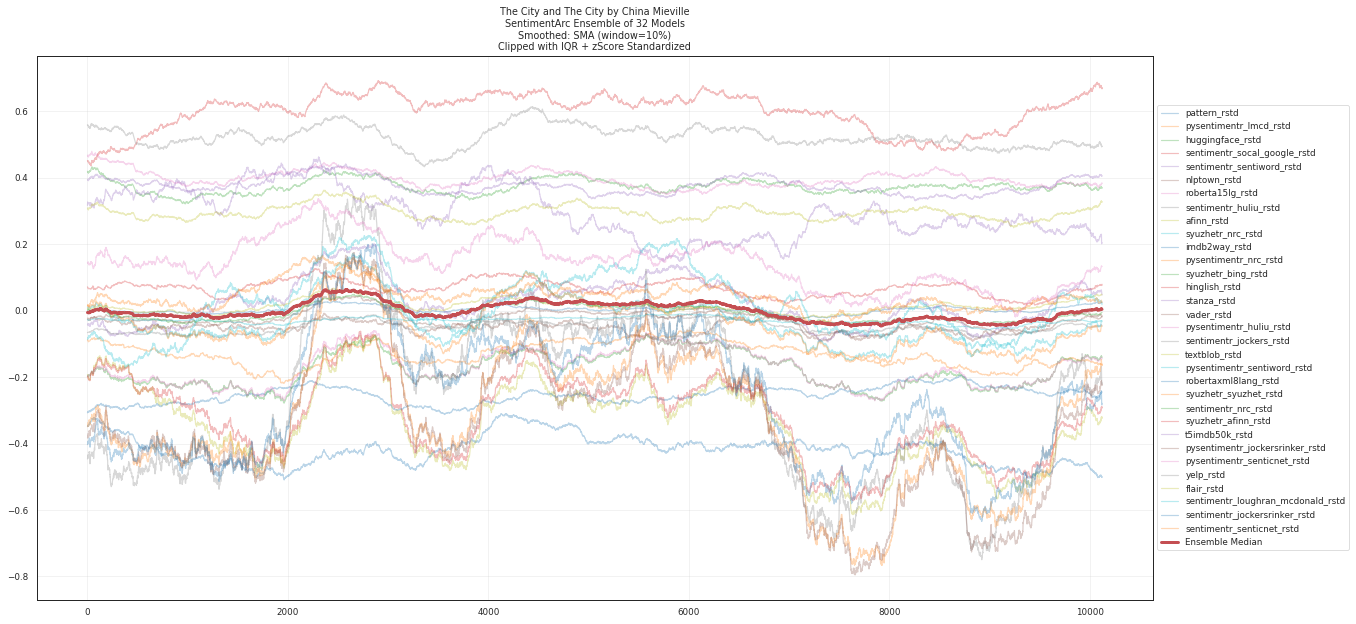

Text #1: scollins_thehungergames1


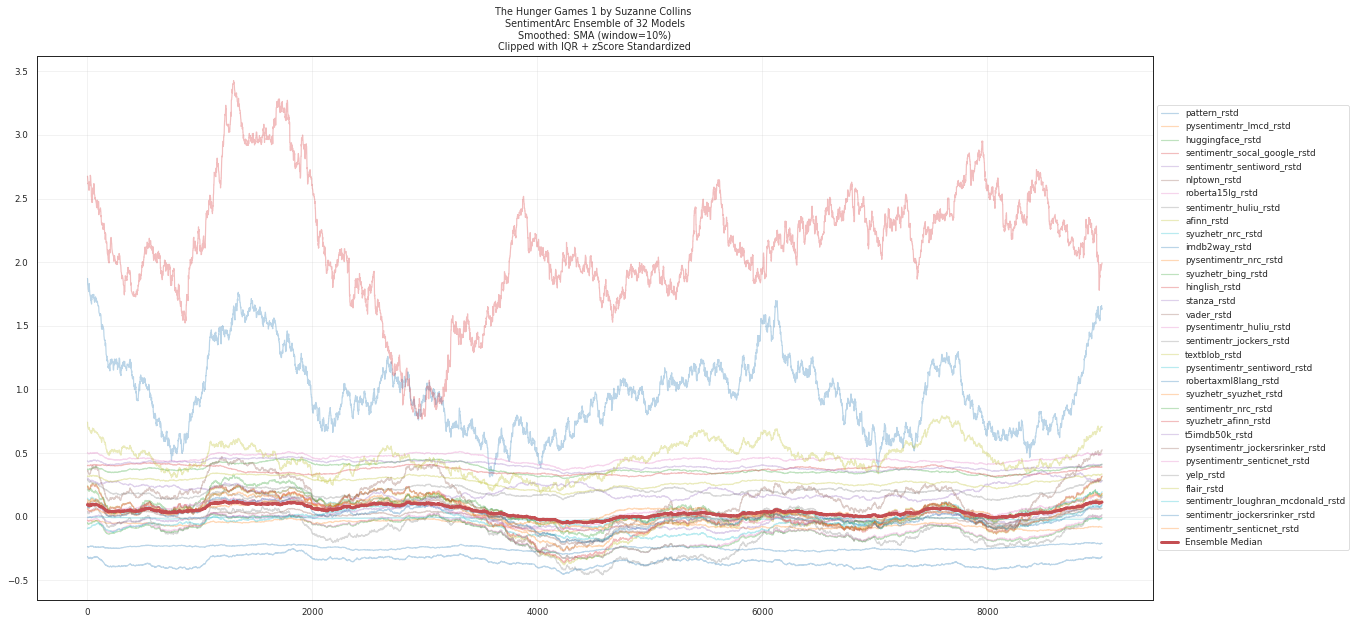

In [67]:
# Deal with Outliers: (a) Manually clip with IQR, or (b) Automatically Scale RobustScaler()

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f'Text #{i}: {atext}')
  
  fig = plt.figure()
  ax = plt.subplot(111)

  models_rstd_ls = []
  for j, amodel in enumerate(ensemble_ls):
    amodel_rstd = f'{amodel}_rstd'
    # print(f'  Model #{j}: {amodel} (Model_Std: {amodel_rstd})')
    # clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['vader'])

    # Option (a): Manually Clip with 2.5*IQR
    # corpus_texts_dt[atext][amodel_rstd] = pd.Series(clip_outliers(corpus_texts_dt[atext][amodel])) # .reshape(-1,1)).flatten())

    # Option (b): Automatically Scale wit scikit-learns ScalerRobust()
    corpus_texts_dt[atext][amodel_rstd] = pd.Series(scaler_robust.fit_transform(np.array(corpus_texts_dt[atext][amodel]).reshape(-1,1)).flatten())

    # Plot
    _ = ax.plot(corpus_texts_dt[atext][amodel_rstd].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rstd, alpha=0.3)

    models_rstd_ls.append(amodel_rstd)

  # Plot Median of Ensemble
  _ = ax.plot(corpus_texts_dt[atext][models_rstd_ls].median(axis=1).rolling(win_10per, center=True, min_periods=0).mean(), label='Ensemble Median', color='r', linewidth=3)

  # Shrink current axis by 20%
  # box = ax.get_position()
  # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

  # Put a legend to the right of the current axis
  _ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.grid(True, alpha=0.3)
  atitle = plt.title(f'{corpus_titles_dt[atext][0]}\nSentimentArc Ensemble of {len(ensemble_ls)} Models\nSmoothed: SMA (window=10%)\nClipped with IQR + zScore Standardized')
  plt.show();

"""
  plot = corpus_texts_dt[atext][models_rstd_ls].rolling(300, center=True, min_periods=0).mean().plot(label='clipped', alpha=0.5)
  plt.grid(True, alpha=0.3)
  plt.show();
""";

## zScore Standardization w/SMA 10%

Text #0: cmieville_thecityandthecity


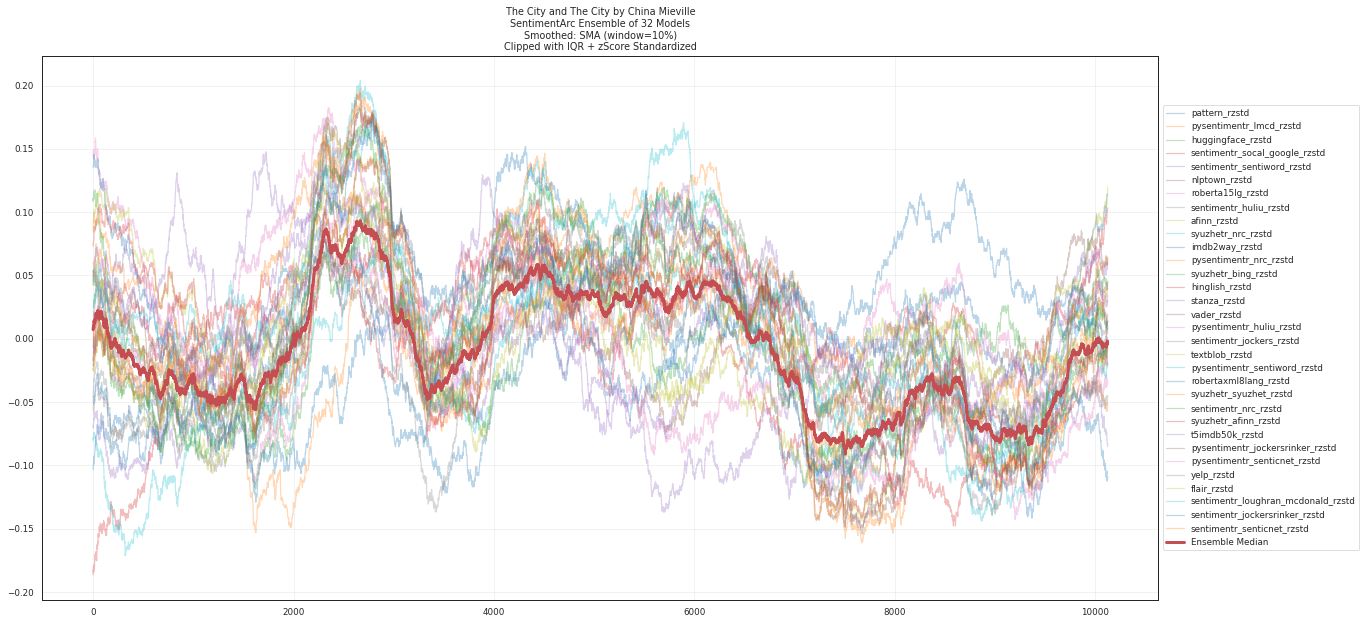

Text #1: scollins_thehungergames1


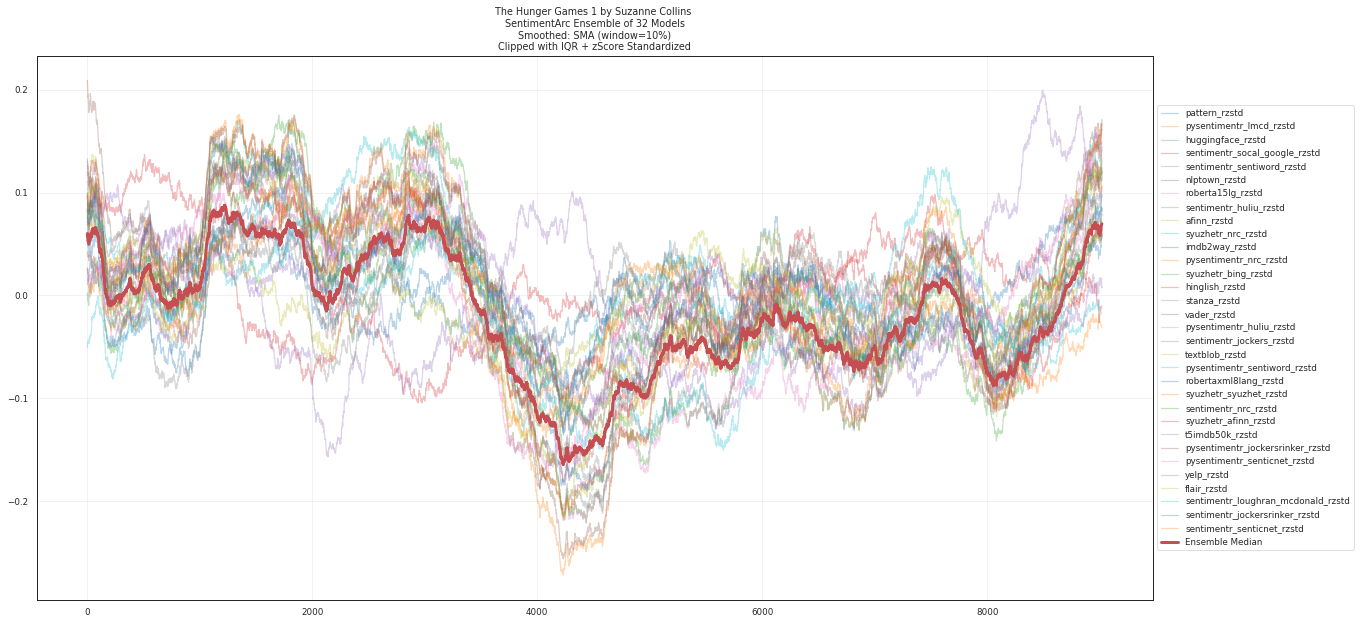

CPU times: user 2 s, sys: 190 ms, total: 2.19 s
Wall time: 2.16 s


In [83]:
%%time

# NOTE:

# zScore Standardization (mean=0, std=1)

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f'Text #{i}: {atext}')

  fig = plt.figure()
  ax = plt.subplot(111)

  models_std_ls = []
  for j, amodel in enumerate(ensemble_ls):
    amodel_rstd = f'{amodel}_rstd'
    amodel_rzstd = f'{amodel}_rzstd'
    # print(f'  Model #{j}: {amodel} (Model_Std: {amodel_rzstd})')
    # clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['vader'])

    # Get SMA 10% window length
    win_10per = int(0.10 * corpus_texts_dt[atext][amodel_rstd].shape[0])


    # UNCOMMENT only ONE of these TWO Options
    # ---------------------------------------
    # Option (a): Manually Clip with IQR
    corpus_texts_dt[atext][amodel_rzstd] = scaler_zscore.fit_transform(np.array(corpus_texts_dt[atext][amodel_rstd]).reshape(-1,1))

    # Option (b): Automatically Scale wit scikit-learns ScalerRobust()
    # corpus_texts_dt[atext][amodel_rzstd] = pd.Series(scaler_robust.fit_transform(np.array(corpus_texts_dt[atext][amodel]).reshape(-1,1)).flatten())

    # Plot amodel_rzstd
    _ = ax.plot(corpus_texts_dt[atext][amodel_rzstd].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rzstd, alpha=0.3)

    models_std_ls.append(amodel_rzstd)

  # Plot Median of Ensemble
  _ = ax.plot(corpus_texts_dt[atext][models_std_ls].median(axis=1).rolling(win_10per, center=True, min_periods=0).mean(), label='Ensemble Median', color='r', linewidth=3)

  # Put a legend to the right of the current axis
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.grid(True, alpha=0.3)
  plt.title(f'{corpus_titles_dt[atext][0]}\nSentimentArc Ensemble of {len(ensemble_ls)} Models\nSmoothed: SMA (window=10%)\nClipped with IQR + zScore Standardized')
  plt.show();

"""

  # Compute ensemble median time series
  # corpus_texts_dt[atext]['deriv_median_rstd'] = corpus_texts_dt[atext][models_std_ls].median(axis=1)

  # Compute ensemble std time series
  # corpus_texts_dt[atext]['deriv_std_rstd'] = corpus_texts_dt[atext][models_std_ls].std(axis=1)
  atitle = f'{corpus_titles_dt[atext][0]}\nSentiment Analysis {len(ensemble_ls)} Models\nClipped (2.5*IQR) and Standardized (zScore)'

  for amodel in ensemble_ls:
    # Plot each Model
    amodel_rzstd = f'{amodel}_rzstd'
    _ = ax.plot(corpus_texts_dt[atext][amodel_rzstd].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rzstd, alpha=0.3)
    plt.show();
  # Plot Median of Ensemble
  _ = ax.plot(corpus_texts_dt[atext][models_std_ls].median(axis=1).rolling(win_10per, center=True, min_periods=0).mean(), label='Ensemble Median', color='r', linewidth=3)

  # Shrink current axis by 20%
  # box = ax.get_position()
  # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

  # Put a legend to the right of the current axis
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  # plt.grid(True, alpha=0.3)
  # plt.title(f'{corpus_titles_dt[atext][0]}\nSentimentArc Ensemble of {len(ensemble_ls)} Models\nSmoothed: SMA (window=10%)\nClipped with IQR + zScore Standardized')
  # plt.show();

  # plot = corpus_texts_dt[atext][models_std_ls].rolling(300, center=True, min_periods=0).mean().plot(title=atitle, alpha=0.3)
  # plot = corpus_texts_dt[atext][models_std_ls].median(axis=1).rolling(300, center=True, min_periods=0).mean().plot(label='median', alpha=0.9, color='r', linewidth=3)

  # plt.grid(True, alpha=0.3)
  # plt.show();

""";

In [84]:
corpus_texts_dt[corpus_titles_ls[0]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 98 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   afinn                               10125 non-null  float64
 1   flair                               10125 non-null  float64
 2   pattern                             10125 non-null  float64
 3   pysentimentr_huliu                  10125 non-null  float64
 4   pysentimentr_jockersrinker          10125 non-null  float64
 5   pysentimentr_lmcd                   10125 non-null  float64
 6   pysentimentr_nrc                    10125 non-null  float64
 7   pysentimentr_senticnet              10125 non-null  float64
 8   pysentimentr_sentiword              10125 non-null  float64
 9   stanza                              10125 non-null  float64
 10  text_clean                          10125 non-null  object 
 11  text_raw                            10125

## zScore Standardization with LOWESS frac=0.08

In [97]:
corpus_texts_dt[corpus_titles_ls[0]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10125 entries, 0 to 10124
Data columns (total 99 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   afinn                               10125 non-null  float64
 1   flair                               10125 non-null  float64
 2   pattern                             10125 non-null  float64
 3   pysentimentr_huliu                  10125 non-null  float64
 4   pysentimentr_jockersrinker          10125 non-null  float64
 5   pysentimentr_lmcd                   10125 non-null  float64
 6   pysentimentr_nrc                    10125 non-null  float64
 7   pysentimentr_senticnet              10125 non-null  float64
 8   pysentimentr_sentiword              10125 non-null  float64
 9   stanza                              10125 non-null  float64
 10  text_clean                          10125 non-null  object 
 11  text_raw                            10125

In [ ]:
%%time

# timeit_res = %timeit -n1 -r1 -o sum(range(1000000))


# NOTE:  1m30s  19:10 on 20220308 Colab Pro/CPU (1 Novel  x 2 Models)
#        5m28s  19:12 on 20220308 Colab Pro/CPU (2 Novels x 2 Models)
#        5m29s  19:39 on 20220308 Colab Pro/CPU (2 Novels x 2 Models) ~ 1m20s per Model per Novel

# zScore Standardization (mean=0, std=1)

afrac_inv = 10

# for i, atext in enumerate(corpus_texts_dt.keys()):
for i, atext in enumerate(corpus_titles_ls[:2]):
  print(f'Text #{i}: {atext}')

  fig = plt.figure()
  ax = plt.subplot(111)

  models_smalowess_rzstd_ls = []
  for j, amodel in enumerate(ensemble_ls):
    # amodel_rstd = f'{amodel}_rstd'
    amodel_rzstd = f'{amodel}_rzstd'
    amodel_sma_rzstd = f'{amodel}_sma_rzstd'
    amodel_smalowess_rzstd = f'{amodel}_smalowess_rzstd'
    print(f'  Model #{j}: {amodel} (Model_Std: {amodel_rzstd})')
    win_10per = int(0.10 * corpus_texts_dt[atext][amodel].shape[0])
    # clip_outliers(corpus_texts_dt[corpus_texts_ls[0]]['vader'])

    # Get values
    x = np.array(range(corpus_texts_dt[atext][amodel].shape[0]))
    y_sma_rzstd = corpus_texts_dt[atext][amodel_rzstd].rolling(win_10per, center=True, min_periods=0).mean().to_numpy()
    

    # UNCOMMENT only ONE of these TWO Options
    # ---------------------------------------

    # Option (a): statsmodels LOWESS
    # sm_x, y_sma_rzstd_pred = sm_lowess(y_sma_rzstd, x,  frac=1./afrac_inv, it=5).T

    # Option (b): moepy LOWESS
    # print('Computing MOEPy LOWESS for RStd Time Series')
    # lowess_moepy.fit(x, y_sma_rzstd, frac=1./afrac_inv)
    # y_sma_rzstd_pred = lowess_moepy.predict(x)
    # moepy fit _sma_rstd
    # print('Computing MOEPy LOWESS for SMA_RStd Time Series')
    lowess_moepy.fit(x, y_sma_rzstd, frac=1./afrac_inv)
    y_smalowess_rzstd_pred = lowess_moepy.predict(x)

    # Save SMA smoothed Robust+zScore Standardized Time Series for Model=amodel
    corpus_texts_dt[atext][amodel_sma_rzstd] = pd.Series(y_sma_rzstd)

    # Save SMA+LOWESS smoothed Robust+zScore Standardized Time Series for Model=amodel
    corpus_texts_dt[atext][amodel_smalowess_rzstd] = pd.Series(y_smalowess_rzstd_pred)

    # Plot amodel_smalowess_rzstd
    # atitle = f'{corpus_titles_dt[atext][0]}\nSentimentArcs Model: {amodel}\nLOWESS Smoothed (frac=1./{afrac_inv})\nClipped (2.5*IQR) and Standardized (zScore)'
    _ = ax.plot(y_sma_rzstd, label=amodel_smalowess_rzstd, alpha=0.3) # .rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rzstd, alpha=0.3)
    _ = ax.plot(corpus_texts_dt[atext][amodel_smalowess_rzstd], label=amodel_smalowess_rzstd, alpha=0.3) # .rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rzstd, alpha=0.3)

    print(f'  Appending {amodel_smalowess_rzstd} to models_smalowess_rzstd_ls')
    models_smalowess_rzstd_ls.append(amodel_smalowess_rzstd)

  # Plot Median of Ensemble
  print('Plotting Median of ensemble')
  models_smalowess_rzstd_ls_median = corpus_texts_dt[atext][models_smalowess_rzstd_ls].median(axis=1)
  _ = ax.plot(models_smalowess_rzstd_ls_median, label='Ensemble Median', color='r', linewidth=3) # .rolling(win_10per, center=True, min_periods=0).mean(), label='Ensemble Median', color='r', linewidth=3)

  # Put a legend to the right of the current axis
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.grid(True, alpha=0.3)
  plt.title(f'{corpus_titles_dt[atext][0]}\nSentimentArc Ensemble of {len(ensemble_ls)} Models\nSmoothed: SMA (window=10%)\nClipped with IQR + zScore Standardized')
  plt.show();


Text #0: cmieville_thecityandthecity
  Model #0: pattern (Model_Std: pattern_rzstd)


## **Save Checkpoint**

In [118]:
FNAME_SENTIMENT_RAW

'sentiment_raw_novels_new_lex2ml.json'

In [119]:
# FNAME_SENTIMENT_CLEAN = 'sentiment_clean_novels_new_ensemble.json'
FNAME_SENTIMENT_CLEAN = 'sentiment_clean_novels_new_ensemble'

In [121]:
!pwd

/gdrive/MyDrive/cdh/sentiment_arcs


In [120]:
# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

# Save sentiment values to subdir_sentiments
write_dict_dfs(corpus_texts_dt, out_file=FNAME_SENTIMENT_CLEAN, out_dir=SUBDIR_SENTIMENT_CLEAN)
print(f'Saving Corpus_Genre: {Corpus_Genre}')
print(f'        Corpus_Type: {Corpus_Type}')
print('\n')

# Verify Dictionary was saved correctly by reading back the *.json datafile
test_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_CLEAN, in_dir=SUBDIR_SENTIMENT_CLEAN)
print(f'These Text Titles:')
test_dt.keys()
print('\n')

corpus_texts_dt[corpus_titles_ls[0]].head()
print('\n')

test_dt[corpus_titles_ls[0]].info()


TypeError: ignored

In [ ]:


# ax.plot(x, y_rstd, alpha=0.1) # , label=f'LOWESS (frac={afrac_inv})') # , color='tomato', linewidth=5)

ax.plot(corpus_texts_dt[atext][amodel_rstd].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rstd, alpha=0.3)
ax.plot(corpus_texts_dt[atext][amodel].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel, alpha=0.3)

# Plot statsmodels LOWESS
# ax.plot(sm_x, sm_y, label=f'LOWESS (frac={afrac_inv})') # , color='tomato', linewidth=5)
# Plot moepy LOWESS
ax.plot(x, y_rstd_pred, label=f'Std LOWESS (frac=1./{afrac_inv})') # , color='tomato', linewidth=5)
ax.plot(x, y_sma_rstd_pred, label=f'Std+SMA LOWESS (frac=1./{afrac_inv})') # , color='tomato', linewidth=5)

atitle = f'{corpus_titles_dt[atext][0]}\nSentimentArcs Model: {amodel}\nLOWESS Smoothed (frac={afrac_inv})\nClipped (2.5*IQR) and Standardized (zScore)'
plt.title(atitle)
plt.legend()
plt.show();

In [ ]:


sm_x, sm_y = sm_lowess(y, x,  frac=1./160., it=5, return_sorted = True).T
plt.plot(sm_x, sm_y, color='tomato', linewidth=5)
# sm_x, sm_y = sm_lowess(y, x,  frac=1./20., it=5, return_sorted = True).T
# plt.plot(sm_x, sm_y, color='green', linewidth=5, alpha=0.3)
# plt.plot(x,)
plt.plot(x, y, 'k.', alpha=0.1)
plt.plot(x, y_roll10, label='SMA 10%')
plt.plot(x, df.sentiment_roll10_interp, label='interpolate roll10')
plt.plot(sm_x, sm_y, label='interpolate LOWESS')
plt.plot(x, df.sentiment_roll10_ewm, label='ewm')
plt.legend(loc='best')

In [ ]:
lowess_grid_dt = {}
crux_ct_ls = []
# temp_df['sent_no'] = pd.Series([x for x in corpus_sents_df['sent_no']])
temp_df['avg_stdscaler'] = corpus_sents_df[models_subset_ls].mean()

fig = plt.figure()
ax = plt.axes()


for afrac in range(frac_start_int, frac_end_int, frac_step_int):
  print(f'Processing afrac = {afrac}')
  # Compute error between subset of models
  afrac_fl = afrac/100
  temp_df = get_lowess(corpus_sents_df, models_ls=models_subset_ls, text_unit='sentence', afrac=afrac_fl, do_plot=False);
  temp_df['minmax_diff'] = temp_df.max(axis=1) - temp_df.min(axis=1)
  diff_sum = temp_df['minmax_diff'].sum()
  print(f"  Sum(minmax_diff): {diff_sum}");
  lowess_grid_dt[afrac] = diff_sum
  # Compute Crux Points
  temp_df['sent_no'] = pd.Series(list(range(temp_df.shape[0])))
  crux_ls = get_crux_points(temp_df,
                            'median',
                            text_type='sentence', 
                            win_per=5, 
                            sec_y_labels=False, 
                            sec_y_height=0, 
                            subtitle_str=' ', 
                            do_plot=False,
                            save2file=False)
  ax.plot(temp_df['sent_no'], temp_df['median'], label=f'frac={afrac}')
  # plt.plot(data=temp_df, x='sent_no', y='median', label=f'frac={afrac}')
  crux_ct_ls.append(len(crux_ls))
  print(f'  {len(crux_ls)} Crux Points')

plt.title(f"{CORPUS_FULL} \n LOWESS Smoothing Grid Search (frac={Frac_Start} to {Frac_End}")
plt.legend()
plt.show()

In [ ]:
corpus_texts_dt[atext][amodel_std].shape[0]

In [ ]:
# np.array(corpus_texts_dt[atext][amodel_std]).reshape(-1,1).shape

np.array(corpus_texts_dt[atext][amodel_std]).reshape(-1,).shape

np.array(corpus_texts_dt[atext][amodel_std]).flatten().shape

In [ ]:
lowess_model.fit(x, y_roll10, frac=0.2)

# x_pred = x # np.linspace(0, 6448, 100)
y_pred = lowess_model.predict(x)

# Plotting
plt.plot(x, y_roll10, label='Sin Wave', zorder=2)
plt.plot(x, y_pred, '--', label='Estimate', color='k', zorder=3)
# plt.scatter(x, y_roll10, label='With Noise', color='C1', s=5, zorder=1)
plt.legend(frameon=False)
# plt.xlim(0, 5)

In [59]:
%%time

# NOTE:  1m21s @14:30 on 20220308 Colab Pro/CPU (1 Novel/1model using moepy)
#        1m21s @14:37 on 20220308 Colab Pro/CPU (1 Novel/1model using moepy)
#        1m21s @14:47 on 20220308 Colab Pro/CPU (1 Novel/1model/2LOWESS using moepy)
#        1m21s @14:37 on 20220308 Colab Pro/CPU (1 Novel/1model using statsmodels)

atext = 'cmieville_thecityandthecity'
amodel = 'afinn'
amodel_rstd = 'afinn_rstd'
afrac_inv = 10

win_10per = int(0.10 * corpus_texts_dt[atext][amodel].shape[0])

x = np.array(range(corpus_texts_dt[atext][amodel].shape[0]))

y = corpus_texts_dt[atext][amodel].to_numpy()
y_rstd = corpus_texts_dt[atext][amodel_rstd].to_numpy()
y_sma_rstd = scaler_zscore.fit_transform(np.array(corpus_texts_dt[atext][amodel_rstd]).reshape(-1,1))

# print(f'x.shape: {x.shape}\ny.shape: {y.shape}')
# sm_x, sm_y = sm_lowess(y, x,  frac=1./afrac_inv, it=5, return_sorted = True).T

# statsmodels
#sm_x, sm_y = sm_lowess(y, x,  frac=1./afrac_inv, it=5).T

# moepy fit _rstd
print('Computing MOEPy LOWESS for RStd Time Series')
lowess_moepy.fit(x, y_rstd, frac=1./afrac_inv)
y_rstd_pred = lowess_moepy.predict(x)
# moepy fit _sma_rstd
print('Computing MOEPy LOWESS for SMA_RStd Time Series')
lowess_moepy.fit(x, y_sma_rstd, frac=1./afrac_inv)
y_sma_rstd_pred = lowess_moepy.predict(x)

atitle = f'{corpus_titles_dt[atext][0]}\nSentimentArcs Model: {amodel}\nLOWESS Smoothed (frac=1./{afrac_inv})\nClipped (2.5*IQR) and Standardized (zScore)'

fig = plt.figure()
ax = plt.subplot(111)

# ax.plot(x, y_rstd, alpha=0.1) # , label=f'LOWESS (frac={afrac_inv})') # , color='tomato', linewidth=5)

ax.plot(corpus_texts_dt[atext][amodel_rstd].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rstd, alpha=0.3)
ax.plot(corpus_texts_dt[atext][amodel].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel, alpha=0.3)

# Plot statsmodels LOWESS
# ax.plot(sm_x, sm_y, label=f'LOWESS (frac={afrac_inv})') # , color='tomato', linewidth=5)
# Plot moepy LOWESS
ax.plot(x, y_rstd_pred, label=f'Std LOWESS (frac=1./{afrac_inv})') # , color='tomato', linewidth=5)
ax.plot(x, y_sma_rstd_pred, label=f'Std+SMA LOWESS (frac=1./{afrac_inv})') # , color='tomato', linewidth=5)

atitle = f'{corpus_titles_dt[atext][0]}\nSentimentArcs Model: {amodel}\nLOWESS Smoothed (frac={afrac_inv})\nClipped (2.5*IQR) and Standardized (zScore)'
plt.title(atitle)
plt.legend()
plt.show();

KeyboardInterrupt: ignored

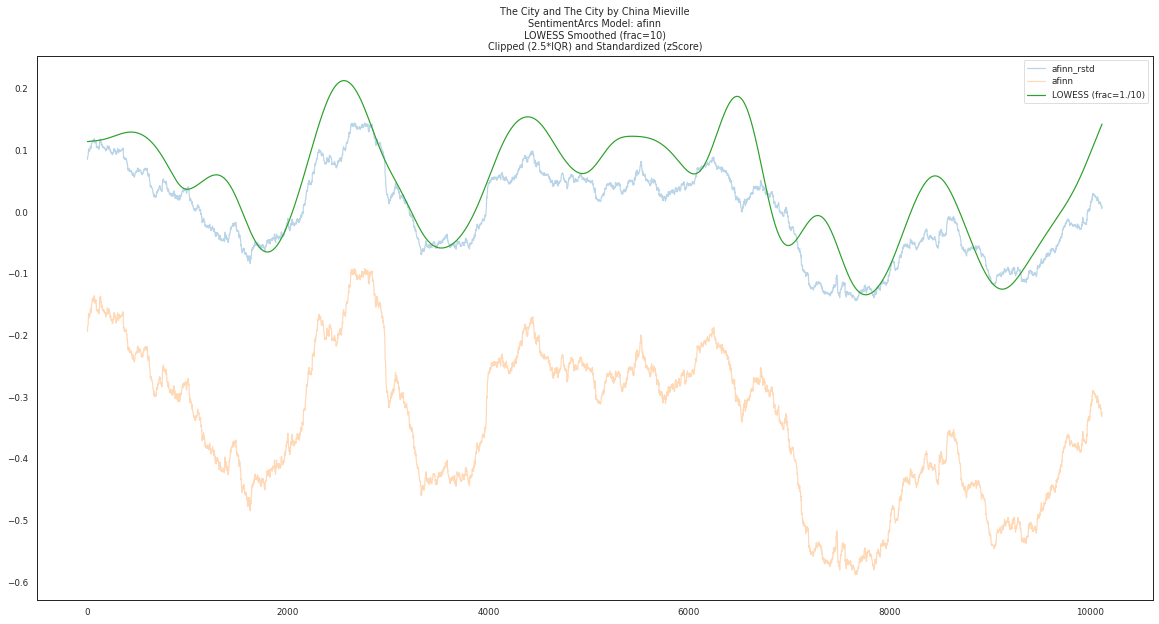

CPU times: user 1min 18s, sys: 785 ms, total: 1min 19s
Wall time: 1min 20s


In [57]:
%%time

# NOTE:  1m21s @14:30 on 20220308 Colab Pro/CPU (1 Novel/1model using moepy)
#        1m21s @14:37 on 20220308 Colab Pro/CPU (1 Novel/1model using moepy)
#        1m21s @14:37 on 20220308 Colab Pro/CPU (1 Novel/1model using statsmodels)
#        1m21s @14:37 on 20220308 Colab Pro/CPU (1 Novel/1model using statsmodels)

atext = 'cmieville_thecityandthecity'
amodel = 'afinn'
amodel_rstd = 'afinn_rstd'
afrac_inv = 10

win_10per = int(0.10 * corpus_texts_dt[atext][amodel].shape[0])

x = np.array(range(corpus_texts_dt[atext][amodel].shape[0]))
y = corpus_texts_dt[atext][amodel].to_numpy()
y_std = corpus_texts_dt[atext][amodel_std].to_numpy()
# print(f'x.shape: {x.shape}\ny.shape: {y.shape}')
# sm_x, sm_y = sm_lowess(y, x,  frac=1./afrac_inv, it=5, return_sorted = True).T

# statsmodels
#sm_x, sm_y = sm_lowess(y, x,  frac=1./afrac_inv, it=5).T

# moepy
lowess_moepy.fit(x, y_std, frac=1./afrac_inv)
y_pred = lowess_moepy.predict(x)

atitle = f'{corpus_titles_dt[atext][0]}\nSentimentArcs Model: {amodel}\nLOWESS Smoothed (frac=1./{afrac_inv})\nClipped (2.5*IQR) and Standardized (zScore)'

fig = plt.figure()
ax = plt.subplot(111)

# ax.plot(x, y_std, alpha=0.1) # , label=f'LOWESS (frac={afrac_inv})') # , color='tomato', linewidth=5)

ax.plot(corpus_texts_dt[atext][amodel_rstd].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rstd, alpha=0.3)
ax.plot(corpus_texts_dt[atext][amodel].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel, alpha=0.3)

# Plot statsmodels LOWESS
# ax.plot(sm_x, sm_y, label=f'LOWESS (frac={afrac_inv})') # , color='tomato', linewidth=5)
# Plot moepy LOWESS
ax.plot(x, y_pred, label=f'LOWESS (frac=1./{afrac_inv})') # , color='tomato', linewidth=5)

atitle = f'{corpus_titles_dt[atext][0]}\nSentimentArcs Model: {amodel}\nLOWESS Smoothed (frac={afrac_inv})\nClipped (2.5*IQR) and Standardized (zScore)'
plt.title(atitle)
plt.legend()
plt.show();

x.shape: (10125,)
y.shape: (10125,)


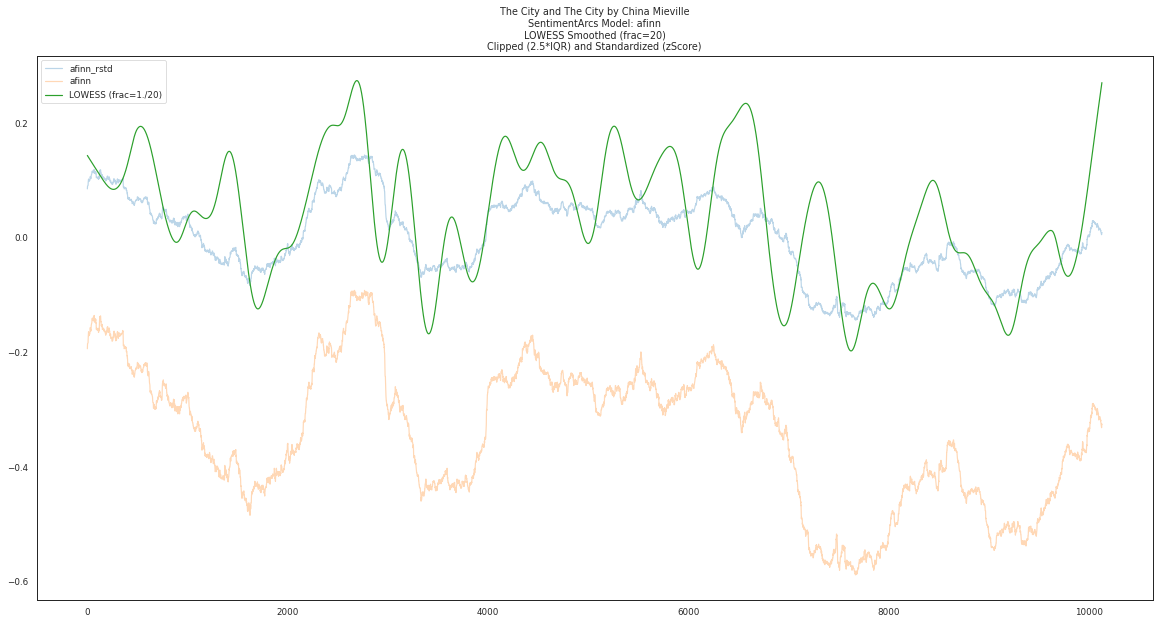

CPU times: user 1min 15s, sys: 822 ms, total: 1min 16s
Wall time: 1min 16s


In [56]:
%%time

# NOTE:  1m21s @14:30 on 20220308 Colab Pro/CPU (1 Novel/1model using moepy)
#        1m21s @14:37 on 20220308 Colab Pro/CPU (1 Novel/1model using moepy)
#        1m21s @14:37 on 20220308 Colab Pro/CPU (1 Novel/1model using statsmodels)
#        1m21s @14:37 on 20220308 Colab Pro/CPU (1 Novel/1model using statsmodels)

atext = 'cmieville_thecityandthecity'
amodel = 'afinn'
amodel_rstd = 'afinn_rstd'
afrac_inv = 10

win_10per = int(0.10 * corpus_texts_dt[atext][amodel].shape[0])

x = np.array(range(corpus_texts_dt[atext][amodel].shape[0]))

y = corpus_texts_dt[atext][amodel].to_numpy()
y_std = corpus_texts_dt[atext][amodel_std].to_numpy()

# print(f'x.shape: {x.shape}\ny.shape: {y.shape}')
# sm_x, sm_y = sm_lowess(y, x,  frac=1./afrac_inv, it=5, return_sorted = True).T

# statsmodels
#sm_x, sm_y = sm_lowess(y, x,  frac=1./afrac_inv, it=5).T

# moepy
lowess_moepy.fit(x, y_std, frac=1./afrac_inv)
y_pred = lowess_moepy.predict(x)

atitle = f'{corpus_titles_dt[atext][0]}\nSentimentArcs Model: {amodel}\nLOWESS Smoothed (frac=1./{afrac_inv})\nClipped (2.5*IQR) and Standardized (zScore)'

fig = plt.figure()
ax = plt.subplot(111)

# ax.plot(x, y_std, alpha=0.1) # , label=f'LOWESS (frac={afrac_inv})') # , color='tomato', linewidth=5)

ax.plot(corpus_texts_dt[atext][amodel_rstd].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rstd, alpha=0.3)
ax.plot(corpus_texts_dt[atext][amodel].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel, alpha=0.3)

# Plot statsmodels LOWESS
# ax.plot(sm_x, sm_y, label=f'LOWESS (frac={afrac_inv})') # , color='tomato', linewidth=5)
# Plot moepy LOWESS
ax.plot(x, y_pred, label=f'LOWESS (frac=1./{afrac_inv})') # , color='tomato', linewidth=5)

atitle = f'{corpus_titles_dt[atext][0]}\nSentimentArcs Model: {amodel}\nLOWESS Smoothed (frac={afrac_inv})\nClipped (2.5*IQR) and Standardized (zScore)'
plt.title(atitle)
plt.legend()
plt.show();

In [ ]:
#%%time

# NOTE:

# LOWESS Smoothing

afrac = 20

for i, atext in enumerate(corpus_texts_dt.keys()):
  print(f'Text #{i}: {atext}')
  
  models_std_ls = []
  for j, amodel in enumerate(ensemble_ls):
    amodel_std = f'{amodel}_rstd'
    # print(f'  Model #{j}: {amodel} (Model_Std: {amodel_std})')

    # Get x/y as np.arrays data types for LOWESS algorithm
    x = np.array((range(corpus_texts_dt[atext][amodel_std].shape[0])))
    y = corpus_texts_dt[atext][amodel_std].to_numpy()
    print(f'x.shape: {x.shape}\ny.shape: {y.shape}')
    sm_x, sm_y = sm_lowess(y, x,  frac=1./afrac, it=5, return_sorted = True).T
    atitle = f'{corpus_titles_dt[atext][0]}\nSentimentArcs Model: {amodel}\nLOWESS Smoothed (frac={afrac})\nClipped (2.5*IQR) and Standardized (zScore)'
    plt.title(atitle)
    plt.plot(sm_x, sm_y) # , color='tomato', linewidth=5)
    plt.show();
    # sm_x, sm_y = sm_lowess(y, x,  frac=1./20., it=5, return_sorted = True).T
    # plt.plot(sm_x, sm_y, color='green', linewidth=5, alpha=0.3)
    # plt.plot(x,)
    # plt.plot(x, y, 'k.', alpha=0.1)
    # plt.plot(x, y_roll10, label='SMA 10%')
    # plt.plot(x, df.sentiment_roll10_interp, label='interpolate roll10')
    # plt.plot(sm_x, sm_y, label='interpolate LOWESS')
    # plt.plot(x, df.sentiment_roll10_ewm, label='ewm')
    # plt.legend(loc='best')

    # Option (a): Manually Clip with IQR
    corpus_texts_dt[atext][amodel_std] = scaler_zscore.fit_transform(np.array(corpus_texts_dt[atext][amodel_std]).reshape(-1,1))

    # Option (b): Automatically Scale wit scikit-learns ScalerRobust()
    # corpus_texts_dt[atext][amodel_std] = pd.Series(scaler_robust.fit_transform(np.array(corpus_texts_dt[atext][amodel]).reshape(-1,1)).flatten())

    models_std_ls.append(amodel_std)

  # Compute ensemble median time series
  # corpus_texts_dt[atext]['deriv_median_rstd'] = corpus_texts_dt[atext][models_std_ls].median(axis=1)
"""
  # Compute ensemble std time series
  # corpus_texts_dt[atext]['deriv_std_rstd'] = corpus_texts_dt[atext][models_std_ls].std(axis=1)
  atitle = f'{corpus_titles_dt[atext][0]}\nSentiment Analysis {len(ensemble_ls)} Models\nClipped (2.5*IQR) and Standardized (zScore)'


  fig = plt.figure()
  ax = plt.subplot(111)

  for amodel in ensemble_ls:
    # Plot each Model
    amodel_rstd = f'{amodel}_rstd'
    ax.plot(corpus_texts_dt[atext][amodel_rstd].rolling(win_10per, center=True, min_periods=0).mean(), label=amodel_rstd, alpha=0.3)
  # Plot Median of Ensemble
  ax.plot(corpus_texts_dt[atext][models_std_ls].median(axis=1).rolling(win_10per, center=True, min_periods=0).mean(), label='Ensemble Median', color='r', linewidth=3)

  # Shrink current axis by 20%
  # box = ax.get_position()
  # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

  # Put a legend to the right of the current axis
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.grid(True, alpha=0.3)
  plt.title(f'{corpus_titles_dt[atext][0]}\nSentimentArc Ensemble of {len(ensemble_ls)} Models\nSmoothed: SMA (window=10%)\nClipped with IQR + zScore Standardized')
  plt.show();

  # plot = corpus_texts_dt[atext][models_std_ls].rolling(300, center=True, min_periods=0).mean().plot(title=atitle, alpha=0.3)
  # plot = corpus_texts_dt[atext][models_std_ls].median(axis=1).rolling(300, center=True, min_periods=0).mean().plot(label='median', alpha=0.9, color='r', linewidth=3)

  # plt.grid(True, alpha=0.3)
  # plt.show();

""";

## Smoothing

In [ ]:
#@markdown **Smoothing Technique**
Smoothing_Algo = "SMA" #@param ["SMA", "LOWESS", "Both"]

#@markdown <hr>

#@markdown **For SMA Smoothing (default 10%)**
Window_Percent = 3 #@param {type:"slider", min:3, max:20, step:1}

#@markdown <hr>

#@markdown **For LOWESS Smoothing (default 0.08)**
Frac_Start = 0.08 #@param {type:"slider", min:0.01, max:0.3, step:0.01}
Frac_End = 0.2 #@param {type:"slider", min:0.01, max:0.2, step:0.01}
Frac_Step = 0.02 #@param {type:"slider", min:0.01, max:0.05, step:0.01}

frac_start_int = int(100*Frac_Start)
frac_end_int = int(100*Frac_End) + 1
frac_step_int = int(100*Frac_Step)


# **[STEP 5] Custom Time Series Processing**

* https://github.com/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb


## Select Models

In [66]:
ensemble_ls

['pysentimentr_huliu',
 'pysentimentr_senticnet',
 'sentimentr_loughran_mcdonald',
 'yelp',
 'flair',
 'nlptown',
 't5imdb50k',
 'stanza',
 'sentimentr_socal_google',
 'sentimentr_jockers',
 'roberta15lg',
 'sentimentr_jockersrinker',
 'sentimentr_sentiword',
 'sentimentr_nrc',
 'sentimentr_senticnet',
 'sentimentr_huliu',
 'vader',
 'syuzhetr_nrc',
 'syuzhetr_syuzhet',
 'syuzhetr_bing',
 'huggingface',
 'afinn',
 'pysentimentr_nrc',
 'pysentimentr_jockersrinker',
 'pattern',
 'hinglish',
 'syuzhetr_afinn',
 'pysentimentr_sentiword',
 'imdb2way',
 'robertaxml8lang',
 'textblob',
 'pysentimentr_lmcd']

In [ ]:
# Sentence Plotly Interactive/Zoom Sentiment Plots

ensemble_subset_ls = []

#@markdown **Lexicon Models**
# Lexicon Models from SyuzhetR
SyuzhetR_AFINN = True #@param {type:"boolean"}
SyuzhetR_Bing = True #@param {type:"boolean"}
SyuzhetR_NRC = True #@param {type:"boolean"}
SyuzhetR_Syuzhet = True #@param {type:"boolean"}

# Standalone Lexicon Models
Pattern = True #@param {type:"boolean"}
AFINN = True #@param {type:"boolean"}

# Leixons ported from SentimentR to Python
pysentimentr_JockerRinker = True #@param {type:"boolean"}
pysentimentr_HuLiu = True #@param {type:"boolean"}
pysentimentr_NRC = True #@param {type:"boolean"}
pysentimentr_SentiWord = True #@param {type:"boolean"}
pysentimentr_SenticNet = True #@param {type:"boolean"}
pysentimentr_lmcd = True #@param {type:"boolean"}

# Future

# https://www.liwc.app/ (LIWC)
# LIWC = False #@param {type:"boolean"}

# https://github.com/nickderobertis/pysentiment (HarvardIV, LMcD)
# HarvardIV = False #@param {type:"boolean"}

# https://mpqa.cs.pitt.edu/ (MPQA)
# MPQA_Arc = False #@param {type:"boolean"}

# http://sentistrength.wlv.ac.uk/ (SentiStrength)
# SentiStrength_Arc = False #@param {type:"boolean"}

Mean_Lexicon = True #@param {type:"boolean"}


#@markdown **Heuristic Models**
SentimentR_JockersRinker = True #@param {type:"boolean"}
SentimentR_Jockers = True #@param {type:"boolean"}
SentimentR_HuLiu = True #@param {type:"boolean"}
SentimentR_SenticNet = True #@param {type:"boolean"}
SentimentR_SentiWord = True #@param {type:"boolean"}
SentimentR_NRC = True #@param {type:"boolean"}
SentimentR_LoughranMcDonald = True #@param {type:"boolean"}
VADER = True #@param {type:"boolean"}

Mean_Heuristic = True #@param {type:"boolean"}

if SentimentR_JockersRinker == True:
  models_subset_ls.append('jockers_rinker')
if SentimentR_Jockers == True:
  models_subset_ls.append('jockers')
if SentimentR_HuLiu == True:
  models_subset_ls.append('huliu')
if SentimentR_SenticNet == True:
  models_subset_ls.append('senticnet')
if SentimentR_SentiWord == True:
  models_subset_ls.append('sentiword')
if SentimentR_NRC == True:
  models_subset_ls.append('nrc')
if SentimentR_LoughranMcDonald == True:
  models_subset_ls.append('lmcd')


#@markdown **Statistical ML Models**
Logistic_Regression = True #@param {type:"boolean"}
Logistic_Regression_cv6 = True #@param {type:"boolean"}
Multinomial_NaiveBayes = True #@param {type:"boolean"}
Multinomial_NaiveBayes_POS = True #@param {type:"boolean"}
Random_Forest = True #@param {type:"boolean"}
XGBoost = True #@param {type:"boolean"}
AutoML_FLAML = True #@param {type:"boolean"}
AutoML_AutoGluon = True #@param {type:"boolean"}

Mean_StatisticalML = True #@param {type:"boolean"}


#@markdown **DNN Models**
FCN = True #@param {type:"boolean"}
LSTM = True #@param {type:"boolean"}
CNN = True #@param {type:"boolean"}
AutoML_Stanza = True #@param {type:"boolean"}
AutoML_Flair = True #@param {type:"boolean"}

Mean_DNN = True #@param {type:"boolean"}


#@markdown **Transformer Models**
RoBERTaLg15_Arc = True #@param {type:"boolean"}
T5IMDB50k_Arc = True #@param {type:"boolean"}
Huggingface_Arc = True #@param {type:"boolean"}
NLPTown_Arc = True #@param {type:"boolean"}
RoBERTaXML8lang_Arc = True #@param {type:"boolean"}
IMDB2way_Arc = True #@param {type:"boolean"}
Hinglish_Arc = True #@param {type:"boolean"}
Yelp_Arc = True #@param {type:"boolean"}
Mean_Subset_Arc = True #@param {type:"boolean"}

Mean_Transformer = True #@param {type:"boolean"}


models_subset_ls = []
if SentimentR_Arc == True:
  models_subset_ls.append('sentimentr')
if Syuzhet_Arc == True:
  models_subset_ls.append('syuzhet')
if Bing_Arc == True:
  models_subset_ls.append('bing')
if SenticNet_Arc == True:
  models_subset_ls.append('senticnet')
if SentiWord_Arc == True:
  models_subset_ls.append('sentiword')
if NRC_Arc == True:
  models_subset_ls.append('nrc')
if AFINN_Arc == True:
  models_subset_ls.append('afinn')
if VADER_Arc == True:
  models_subset_ls.append('vader')
if TextBlob_Arc == True:
  models_subset_ls.append('textblob')
if Flair_Arc == True:
  models_subset_ls.append('flair')
if Pattern_Arc == True:
  models_subset_ls.append('pattern')
if Stanza_Arc == True:
  models_subset_ls.append('stanza')
if Mean_All_Arc == True:
  models_subset_ls.append('mean_all')

if len(str(SMA_Window_Percent)) == 1:
  roll_str = 'roll0' + str(SMA_Window_Percent)
else:
  roll_str = 'roll' + str(SMA_Window_Percent%100)

print(f'Rolling Window: {roll_str}')

plot_models(models_subset_ls, models_type='baseline', text_unit='sent_no', win_per=SMA_Window_Percent)



## Select Smoothing and Hyperparameters

### Option (a): Simple Moving Average (default window = 10%)

In [ ]:

SMA_Window_Percent = 10 #@param {type:"slider", min:1, max:20, step:1}

### Option (b): LOWESS (default frac=.08)

In [ ]:
Frac_Start = 0.08 #@param {type:"slider", min:0.01, max:0.3, step:0.01}
Frac_End = 0.2 #@param {type:"slider", min:0.01, max:0.2, step:0.01}
Frac_Step = 0.02 #@param {type:"slider", min:0.01, max:0.05, step:0.01}

frac_start_int = int(100*Frac_Start)
frac_end_int = int(100*Frac_End) + 1
frac_step_int = int(100*Frac_Step)

print('GRID SEARCH --------------------\n')

lowess_grid_dt = {}
crux_ct_ls = []
# temp_df['sent_no'] = pd.Series([x for x in corpus_sents_df['sent_no']])
temp_df['avg_stdscaler'] = corpus_sents_df[models_subset_ls].mean()

fig = plt.figure()
ax = plt.axes()


for afrac in range(frac_start_int, frac_end_int, frac_step_int):
  print(f'Processing afrac = {afrac}')
  # Compute error between subset of models
  afrac_fl = afrac/100
  temp_df = get_lowess(corpus_sents_df, models_ls=models_subset_ls, text_unit='sentence', afrac=afrac_fl, do_plot=False);
  temp_df['minmax_diff'] = temp_df.max(axis=1) - temp_df.min(axis=1)
  diff_sum = temp_df['minmax_diff'].sum()
  print(f"  Sum(minmax_diff): {diff_sum}");
  lowess_grid_dt[afrac] = diff_sum
  # Compute Crux Points
  temp_df['sent_no'] = pd.Series(list(range(temp_df.shape[0])))
  crux_ls = get_crux_points(temp_df,
                            'median',
                            text_type='sentence', 
                            win_per=5, 
                            sec_y_labels=False, 
                            sec_y_height=0, 
                            subtitle_str=' ', 
                            do_plot=False,
                            save2file=False)
  ax.plot(temp_df['sent_no'], temp_df['median'], label=f'frac={afrac}')
  # plt.plot(data=temp_df, x='sent_no', y='median', label=f'frac={afrac}')
  crux_ct_ls.append(len(crux_ls))
  print(f'  {len(crux_ls)} Crux Points')

plt.title(f"{CORPUS_FULL} \n LOWESS Smoothing Grid Search (frac={Frac_Start} to {Frac_End}")
plt.legend()
plt.show()


In [ ]:
# Plot Declining Error as a function of LOWESS frac

# lowess_grid_dt

lists = sorted(lowess_grid_dt.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
# plt.plot(x, y, label='Interplot Error')

adj_factor = 40
crux_ct_adj_ls = [adj_factor * x for x in crux_ct_ls]

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make first plot: Error
ax.plot(x, y, color="red", label='Coherence Error', marker="o")
# set x-axis label
ax.set_xlabel("LOWESS frac Hyperparemeter",fontsize=14)
# set y-axis label
ax.set_ylabel("Coherence Error",color="red",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make second plot: Crux Count, with different y-axis using second axis object
ax2.plot(x, crux_ct_ls,color="blue",label='Crux Count', marker="o")
ax2.set_ylabel("Crux Count",color="blue",fontsize=14)
plt.title(f'{CORPUS_FULL} Sentence Sentiment \n Grid Search for LOWESS [frac] Hyperparemeter')
plt.legend(loc='best')
plt.show();
"""
# save the plot as a file
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')
""";

### DTW and Agglomerative Hierarichal Clustering

## Compute Metrics

### Correlation

In [ ]:
# Sentence Heatmap Correlation of StdScaler Roll100 Sentiments
# Depends on 'col_stdscaler_rollwin_ls' defined in prior code cell

Correlation_Algo = "spearman" #@param ["pearson", "spearman", "kendall"]
# corr_methods_ls = ['pearson', 'spearman', 'kendall']

col_stdscaler_rollwin_ls = []
for amodel in models_baseline_ls:
  col_amodel_stdscaler_rollwin = f'{amodel}_stdscaler_{roll_str}'
  col_stdscaler_rollwin_ls.append(col_amodel_stdscaler_rollwin)
print(f'DEFAULT Models:\n\n    col_stdscaler_rollwin_ls: {col_stdscaler_rollwin_ls}')

# OPTIONAL EDIT: Manually select problematic model to remove from analysis 
#                (e.g. Pattern can misbehave at times)
model_root_bad = 'pattern'
# model_root_bad = ''
col_stdscaler_rollwin_ls = [x for x in col_stdscaler_rollwin_ls if model_root_bad not in x]

print(f'MODIFED Models:\n\n    col_stdscaler_rollwin_ls: {col_stdscaler_rollwin_ls}')

corr_df = corpus_sents_df[col_stdscaler_rollwin_ls].dropna(axis=0, how='any').corr(method=Correlation_Algo)

# Customize the heatmap of the corr_meat correlation matrix and rotate the x-axis labels
fig = sns.clustermap(corr_df, # corpus_sents_df[col_stdscaler_rollwin_ls].dropna(axis=0, how='any').corr(method=corr_method),
                    row_cluster=True,
                    col_cluster=True,
                    figsize=(10, 10))


plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.title(f'{CORPUS_FULL} Sentence Sentiment for Baseline Model Sentiments\n {Correlation_Algo.capitalize()} Correlation - StdScale Sentiments SMA ({roll_str.capitalize()})')
plt.show();

### Model-Corpus Compatibility (MCC)

### Model Family Coherence (MFC)

### Ensemble-Corpus Compatibility (MCC)

# **[STEP 6] Crux Detection and Extraction**

## **Search Corpus for Substring**

INSTRUCTIONS:

* In [Search_for_Substring] enter a Substring to search for in the Corpus

* Enter a Substring long enough/unique enough so only a reasonable number of Sentences will be returned

* Substring can contain spaces/punctuation, for example: 'in the garden'

In [ ]:
# Search Corpus Sentences for Substring

Search_for_Substring = "abuse" #@param {type:"string"}

sentno_matching_ls = corpus_sents_df[corpus_sents_df['sent_raw'].str.contains(Search_for_Substring, regex=False)]['sent_no']

for i, asentno in enumerate(sentno_matching_ls):
  # sentno, sentraw = asent
  print(f"\n\nMatch #{i}: Sentence #{asentno}\n\n")
  sent_highlight = re.sub(Search_for_Substring, Search_for_Substring.upper(), corpus_sents_df.iloc[asentno]['sent_raw'])
  print(f'    {sent_highlight}')

## **Plot Top-n Crux Peaks/Valleys for selected Model**

INSTRUCTIONS:

* Select [Crux_Window_Percent] exclusive zone around Crux Points as a percentage of Corpus length

* [Sentiment_Model] Select a Sentiment Analysis model

* Select [Anomaly_Detction] to plot raw Sentiment values to detect outlier/anomaly Sentences. Leave unchecked to plot SMA smoothed Sentiment arc and detect Crux points

* Select [Save_to_File] to also save plot to external *.png file

In [ ]:
Crux_Window_Percent = 5 #@param {type:"slider", min:1, max:20, step:1}
Baseline_SMA_Model = "SentiWord" #@param ["SentimentR", "SyuzhetR", "Bing", "SenticNet", "SentiWord", "NRC", "AFINN", "VADER", "TextBlob", "Flair", "Pattern", "Stanza"]
Anomaly_Detection = False #@param {type:"boolean"}
Vertical_Labels = True #@param {type:"boolean"}
Vertical_Labels_Height = -0.1 #@param {type:"slider", min:-50, max:50, step:0.1}
Save_to_Report = False #@param {type:"boolean"}

if Baseline_SMA_Model == 'SentimentR':
  model_selected = f'sentimentr'
if Baseline_SMA_Model == 'SyuzhetR':
  model_selected = f'syuzhet'
if Baseline_SMA_Model == 'Bing':
  model_selected = f'bing'
if Baseline_SMA_Model == 'SenticNet':
  model_selected = f'senticnet'
if Baseline_SMA_Model == 'SentiWord':
  model_selected = f'sentiword'
if Baseline_SMA_Model == 'NRC':
  model_selected = f'nrc'
if Baseline_SMA_Model == 'AFINN':
  model_selected = f'afinn'
if Baseline_SMA_Model == 'VADER':
  model_selected = f'vader'
if Baseline_SMA_Model == 'TextBlob':
  model_selected = f'textblob'
if Baseline_SMA_Model == 'Flair':
  model_selected = f'flair'
if Baseline_SMA_Model == 'Pattern':
  model_selected = f'pattern'
if Baseline_SMA_Model == 'Stanza':
  model_selected = f'stanza'

if Anomaly_Detection == False:
  # (a) Use Sentence SMA smoothed Sentiment models to detect Crux Points
  model_selected_fullname = f'{model_selected}_stdscaler_{roll_str}'
else:
  # (b)Use Sentence Raw Sentiment models to detect outliers
  model_selected_fullname = f'{model_selected}'


# TODO: enable multiple overlay crux points with underlying mean/median arc
corpus_models_selected_ls = [model_selected_fullname]

# Warning: requires definitions of: x, section_sents_df
#          so Baseline models must be run first

for amodel in corpus_models_selected_ls:
  corpus_cruxes_all_dt[amodel] = get_crux_points(ts_df=corpus_sents_df, 
                                         col_series=corpus_models_selected_ls, 
                                         text_type='sentence', 
                                         win_per=Crux_Window_Percent, 
                                         sec_y_labels=Vertical_Labels,
                                         sec_y_height=Vertical_Labels_Height, 
                                         subtitle_str= '5% Crux ', 
                                         do_plot=True, 
                                         save2file=False);
  
model_crux_ls = corpus_cruxes_all_dt[amodel]
# model_crux_ls;

## **Context around Top-n Crux Peaks/Valleys**

INSTRUCTIONS:

* Select [Get_Peak_Cruxes] to retrieve Peaks (if unchecked Valleys are retrieved)

* [Get_n_Cruxes] determines how many Top-n Cruxes to retrieve

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Crux Point Details
Get_Peak_Cruxes = False #@param {type:"boolean"}
Get_n_Cruxes = 20 #@param {type:"slider", min:1, max:20, step:1}
Sort_by_SentenceNo = True #@param {type:"boolean"}

# Context Details
No_Paragraphs_on_Each_Side = 2 #@param {type:"slider", min:0, max:5, step:1}
Highlight_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}


if Sort_by_SentenceNo == True:
  sort_on = 'sent_no'
else:
  sort_on = 'sentiment_val'


print(f'Crux Report --------------------\n')
print(f'            Corpus: {CORPUS_FULL}')
print(f'            Model: {Baseline_SMA_Model}')
print(f'            Crux Win%: {Crux_Window_Percent}')
print(f'            SMA Win%: {roll_str}')

if Save_to_Report == False:
  crux_sortsents_report(model_crux_ls, 
                        ts_df = corpus_sents_df,
                        library_type='baseline', 
                        top_n=Get_n_Cruxes, 
                        get_peaks=Get_Peak_Cruxes,
                        sort_by = sort_on, # sent_no, or abs(polarity)
                        n_sideparags=No_Paragraphs_on_Each_Side,
                        sentence_highlight=Highlight_Sentence)
else:
  # import sys
  # with open('filename.txt', 'w') as f:
  #   print('This message will be written to a file.', file=f)
  # https://www.kite.com/python/answers/how-to-get-stdout-and-stderr-from-a-process-as-a-string-in-python
  # process = subprocess.run(["echo", "This goes to stdout"], capture_output=True)
  # stdout_as_str = process.stdout.decode("utf-8")
  # print(stdout_as_str)
  temp_out = StringIO()
  sys.stdout = temp_out
  crux_sortsents_report(model_crux_ls, top_n=Get_n_Cruxes, get_peaks=Get_Peak_Cruxes, n_sideparags=No_Paragraphs_on_Each_Side)
  print(temp_out)
  # attempt to save temp_out to generated filename
  sys.stdout = sys.__stdout__


In [ ]:
asent_no = 124
corpus_df = corpus_sents_df
asent_raw = str(corpus_df[corpus_df['sent_no'] == int(asent_no)]['sent_raw'].values[0])
asent_raw

## **Zoom in on Context surrounding a particular Crux Point**

INSTRUCTIONS:

* Enter [Crux_Sentence_No] that matches a Crux point/Sentence No you want to explore

* Enter [No_Paragraphs_on_Each_Side] to retrieve this many Paragraphs before and after the Paragraph containing your Crux Sentence (e.g. 2 will bring back 5 paragraphs centered around the Paragraph containing the Crux Sentence)

* Select [Highlight_Crux_Sentence] to have the Crux Sentence converted to ALL CAPS for easier identification. The Paragraph containing the Crux Sentence will be prefaced with a '<*>' as well.

* Select [Save_to_File] to also save output to external *.txt file

In [ ]:
# Select details about the Crux Point Context to Retrieve

# print(f'Last Sentence No: {corpus_sents_df.shape[0]}')
Crux_Sentence_No =  200#@param {type:"number"}
No_Paragraphs_on_Each_Side = 4 #@param {type:"slider", min:0, max:10, step:1}
Highlight_Crux_Sentence = True #@param {type:"boolean"}
Save_to_Report = False #@param {type:"boolean"}

corpus_sents_len = corpus_sents_df.shape[0]

# if (Crux_Sentence_No >= No_Paragraphs_on_Each_Side) & (Crux_Sentence_No+No_Paragraphs_on_Each_Side <= corpus_parag_len):
# get_sentnocontext_report()
# try:

# get_sentnocontext_report(ts_df = corpus_sents_df, the_sent_no=7, the_n_sideparags=1, the_sent_highlight=True):
get_sentnocontext_report(ts_df=corpus_sents_df, the_sent_no=Crux_Sentence_No, the_n_sideparags=No_Paragraphs_on_Each_Side, the_sent_highlight=Highlight_Crux_Sentence)

# except:
#   print('ERROR')
# else:
#   print(f'ERROR: The combination of your [Crux_Sentence_No] and [No_Pargraphs_on_Each_Side]\n       results in a window outside the range of the Corpus Paragraphs.\n\n       Try again with different values.')

# **END OF NOTEBOOK**